# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
import wandb

In [2]:
torch.__version__

'2.2.2'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from base.dgd.nn import NB_Module
from base.dgd.DGD import DGD

# get the new stuff
from base.utils.helpers import set_seed, get_activation
from base.model.decoder_debug import Decoder
from base.data.combined import GeneExpressionDatasetCombined
from base.engine.train import train_midgd

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 14

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cuda


# Load Data

In [5]:
# tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_transposed.tsv", sep='\t', index_col=[0])
# tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_transposed.tsv", sep='\t', index_col=[0])
tcga_mrna = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])
tcga_mirna = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])

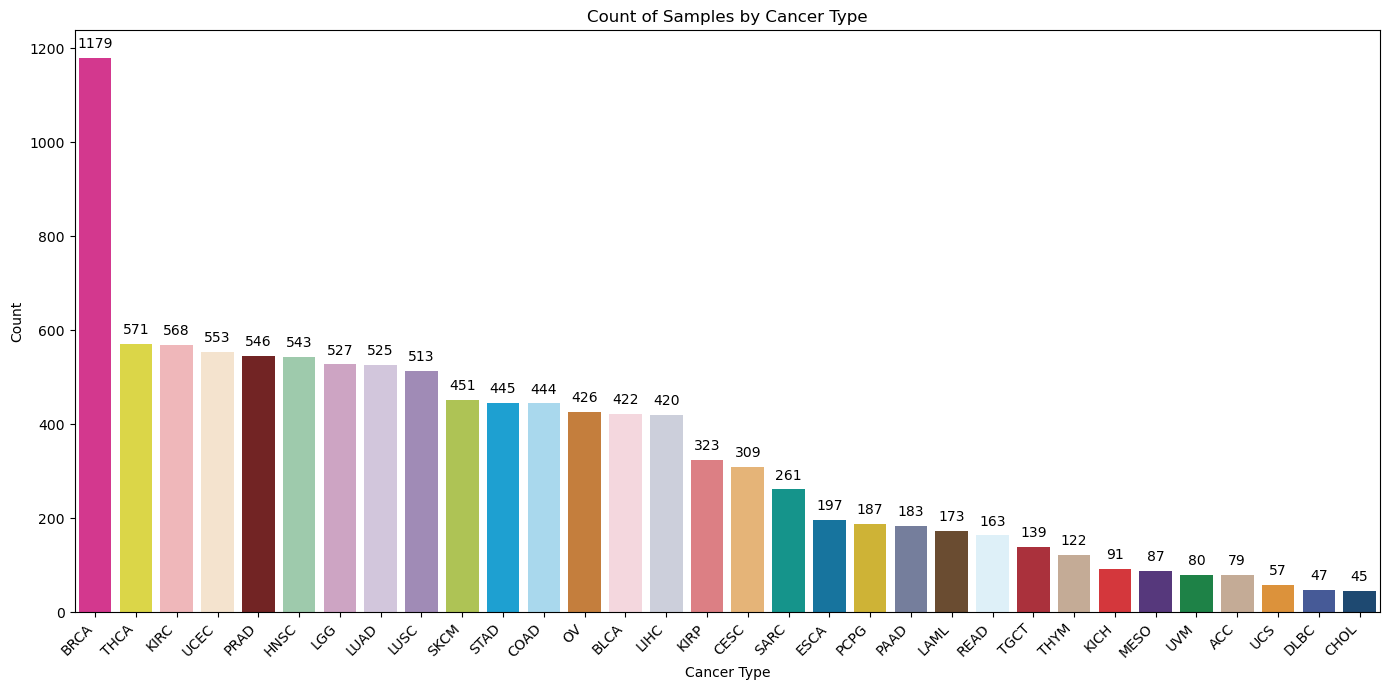

In [6]:
color_mapping = dict(zip(tcga_mrna['cancer_type'], tcga_mrna['color']))

primary_site_counts = tcga_mrna['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(14, 7))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Count of Samples by Cancer Type')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels to show them more clearly

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 10),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
plt.show()

In [7]:
# shuffle the data
tcga_mrna = tcga_mrna.sample(frac=1, random_state=seed)
tcga_mirna = tcga_mirna.sample(frac=1, random_state=seed)

In [96]:
# make data split for train, validation, and test sets
train_ratio, val_ratio, test_ratio = 0.85, 0.15, 0.

# Calculate split indices
total_samples = len(tcga_mrna)
train_end = int(train_ratio * total_samples)

# Split the data
train_mrna = tcga_mrna.iloc[:train_end]
val_mrna = tcga_mrna.iloc[train_end:]

train_mirna = tcga_mirna.iloc[:train_end]
val_mirna = tcga_mirna.iloc[train_end:]

In [97]:
is_subset = False
n = 2500

if is_subset:
    # Extract the expression data (excluding the last four columns)
    expression_data = train_mrna.iloc[:, :-4]
    variances = expression_data.var(axis=0)
    top_gene = variances.nlargest(n).index
    selected_columns = expression_data[top_gene].columns

    annot = train_mrna.iloc[:,-4:].columns
    train_mrna = train_mrna[selected_columns.append(annot)]
    val_mrna = val_mrna[selected_columns.append(annot)]

In [98]:
# Train, val, and test data loaders
batch_size = 256

# Default scaling_type = "mean"
train_dataset = GeneExpressionDatasetCombined(train_mrna, train_mirna)
validation_dataset = GeneExpressionDatasetCombined(val_mrna, val_mirna)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=True,
                                                num_workers=num_workers)

In [112]:
# make data split for train and validation sets
mrna_out_dim = train_mrna.shape[1]-4
mirna_out_dim = train_mirna.shape[1]-4

In [113]:
print(train_dataset.mrna_data.shape)
print(validation_dataset.mrna_data.shape)

print(train_dataset.mirna_data.shape)
print(validation_dataset.mirna_data.shape)
print(mrna_out_dim)
print(mirna_out_dim)

torch.Size([9074, 19784])
torch.Size([1602, 19784])
torch.Size([9074, 2450])
torch.Size([1602, 2450])
19784
2450


# Model Setup

In [101]:
n_tissues = len(np.unique(train_dataset.label))
n_tissues

32

In [102]:
# hyperparameters
latent_dim = 20
hidden_dims = [128, 128]
reduction_type = "sum" # output loss reduction
activation = "leaky_relu"

In [103]:
# decoder setup

# set up an output module for the miRNA expression data
mirna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], 256),
    get_activation(activation),
    nn.Linear(256, mirna_out_dim)
    )
output_mirna_layer = NB_Module(mirna_out_fc, mirna_out_dim, scaling_type="mean")
output_mirna_layer.n_features = mirna_out_dim

# set up an output module for the mRNA expression data
mrna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], 1024),
    get_activation(activation),
    nn.Linear(1024, mrna_out_dim)
    )
output_mrna_layer = NB_Module(mrna_out_fc, mrna_out_dim, scaling_type="mean")
output_mrna_layer.n_features = mrna_out_dim

# set up the decoder
decoder = Decoder(latent_dim, hidden_dims, [output_mirna_layer, output_mrna_layer], activation=activation).to(device)

# setup gmm init
gmm_mean_scale = 5.0 # usually between 2 and 10
sd_mean_init = 0.2 * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20
gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}

In [104]:
# init a DGD model
dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec=gmm_spec
)

In [105]:
dgd.parameters

<bound method Module.parameters of DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (out_modules): ModuleList(
      (0): NB_Module(
        (fc): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(in_features=256, out_features=2450, bias=True)
        )
      )
      (1): NB_Module(
        (fc): Sequential(
          (0): Linear(in_features=128, out_features=1024, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(in_features=1024, out_features=19784, bias=True)
        )
      )
    )
  )
  (gmm): GaussianMixture()
)>

In [107]:
# train for n epochs and plot learning curves
learning_rates = {'dec':0.001,'rep':0.01,'gmm':0.01}
weight_decay = 0.
betas = (0.5, 0.7)

nepochs = 101
pr = 5 # how often to print epoch
plot = 50 # how often to print plot

sample_mirna = ['MIMAT0000421', 'MIMAT0000422', 'MIMAT0000435', 'MIMAT0000728']
sample_index = [tcga_mirna.columns.get_loc(a) for a in sample_mirna]
subset = sample_index[0]
sample_index = [1382, 1310, 34, 360, 
                765, 999, 2000, 93,
                0, 10, 20, 300, 
                123, 345, 456, 567,
                789, 12, 34, 56]

In [108]:
print("Hyperparameters:")
print(f"Latent dimension: {latent_dim}")
print(f"Learning rates: {learning_rates}")
print(f"Weight decay: {weight_decay}")
print(f"betas: {betas}")
print(f"Number of epochs: {nepochs}")
print(f"Hidden dimensions: {hidden_dims}")
print(f"Batch size: {batch_size}")
print(f"Reduction type: {reduction_type}")

Hyperparameters:
Latent dimension: 20
Learning rates: {'dec': 0.001, 'rep': 0.01, 'gmm': 0.01}
Weight decay: 0.0
betas: (0.5, 0.7)
Number of epochs: 101
Hidden dimensions: [128, 128]
Batch size: 256
Reduction type: sum


# Training

  0%|                                                                                                                                                                                                                                                                                     | 0/101 [00:00<?, ?it/s]

0 train_recon_mirna: 11.273860379285063 train_recon_mrna: 8.98791743646012 train_gmm: 11.427562416485287 train_mse: 1066716.125 train_mae: 197.3460693359375 train_r2: 0.01435178518295288 train_spearman: 0.2872648239135742 train_pearson: 0.14374271035194397 train_expl_var: 0.014351844787597656 train_msle: 17.06195831298828
0 test_recon_mrna: 7.816096678080826 test_gmm: 7.233235158932194 test_mse: 26673386.0 test_mae: 1137.228515625 test_r2: 0.012432754039764404 test_spearman: 0.25754791498184204 test_pearson: 0.11923802644014359 test_expl_var: 0.012432754039764404 test_msle: 31.207542419433594


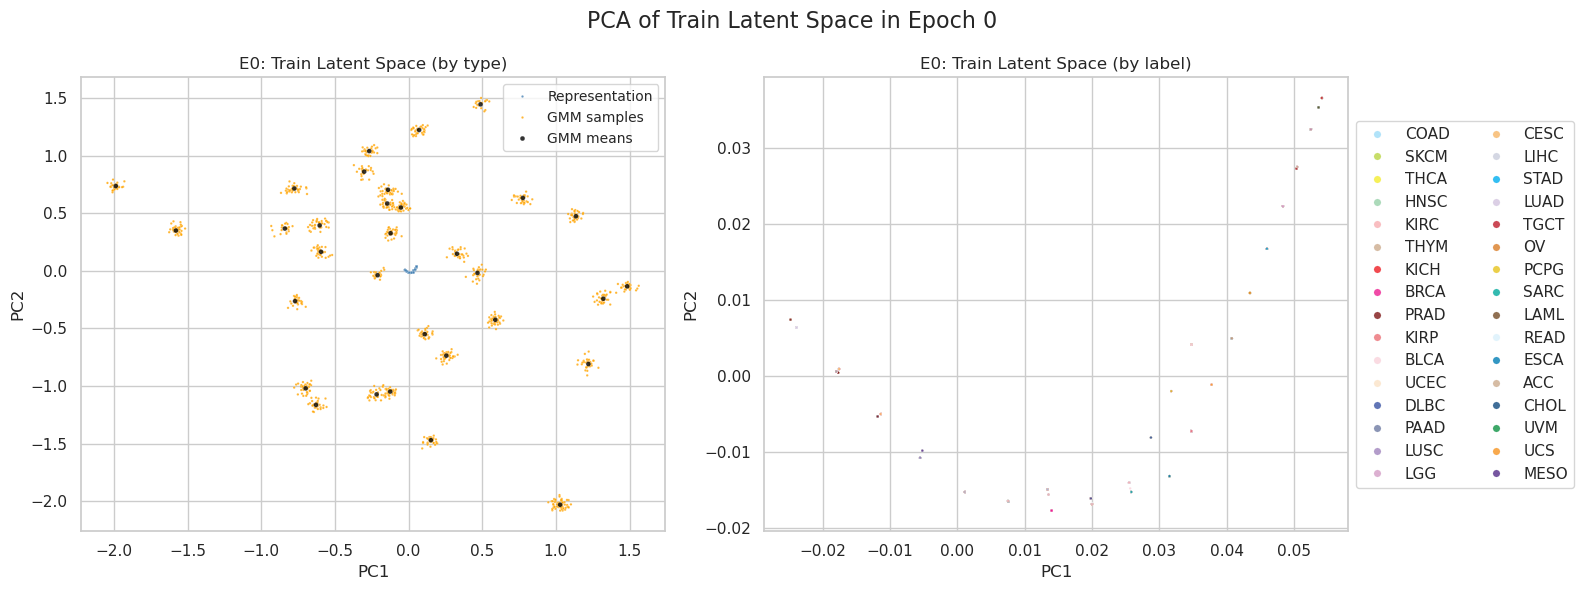

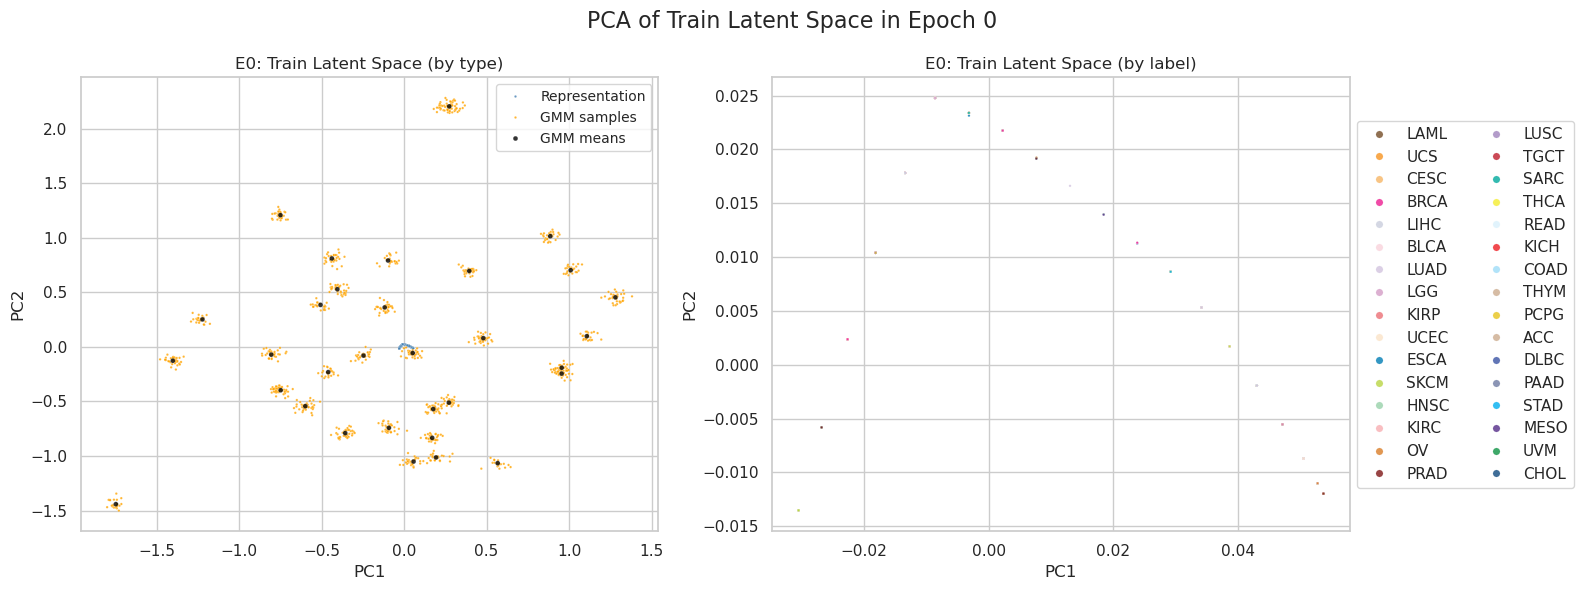

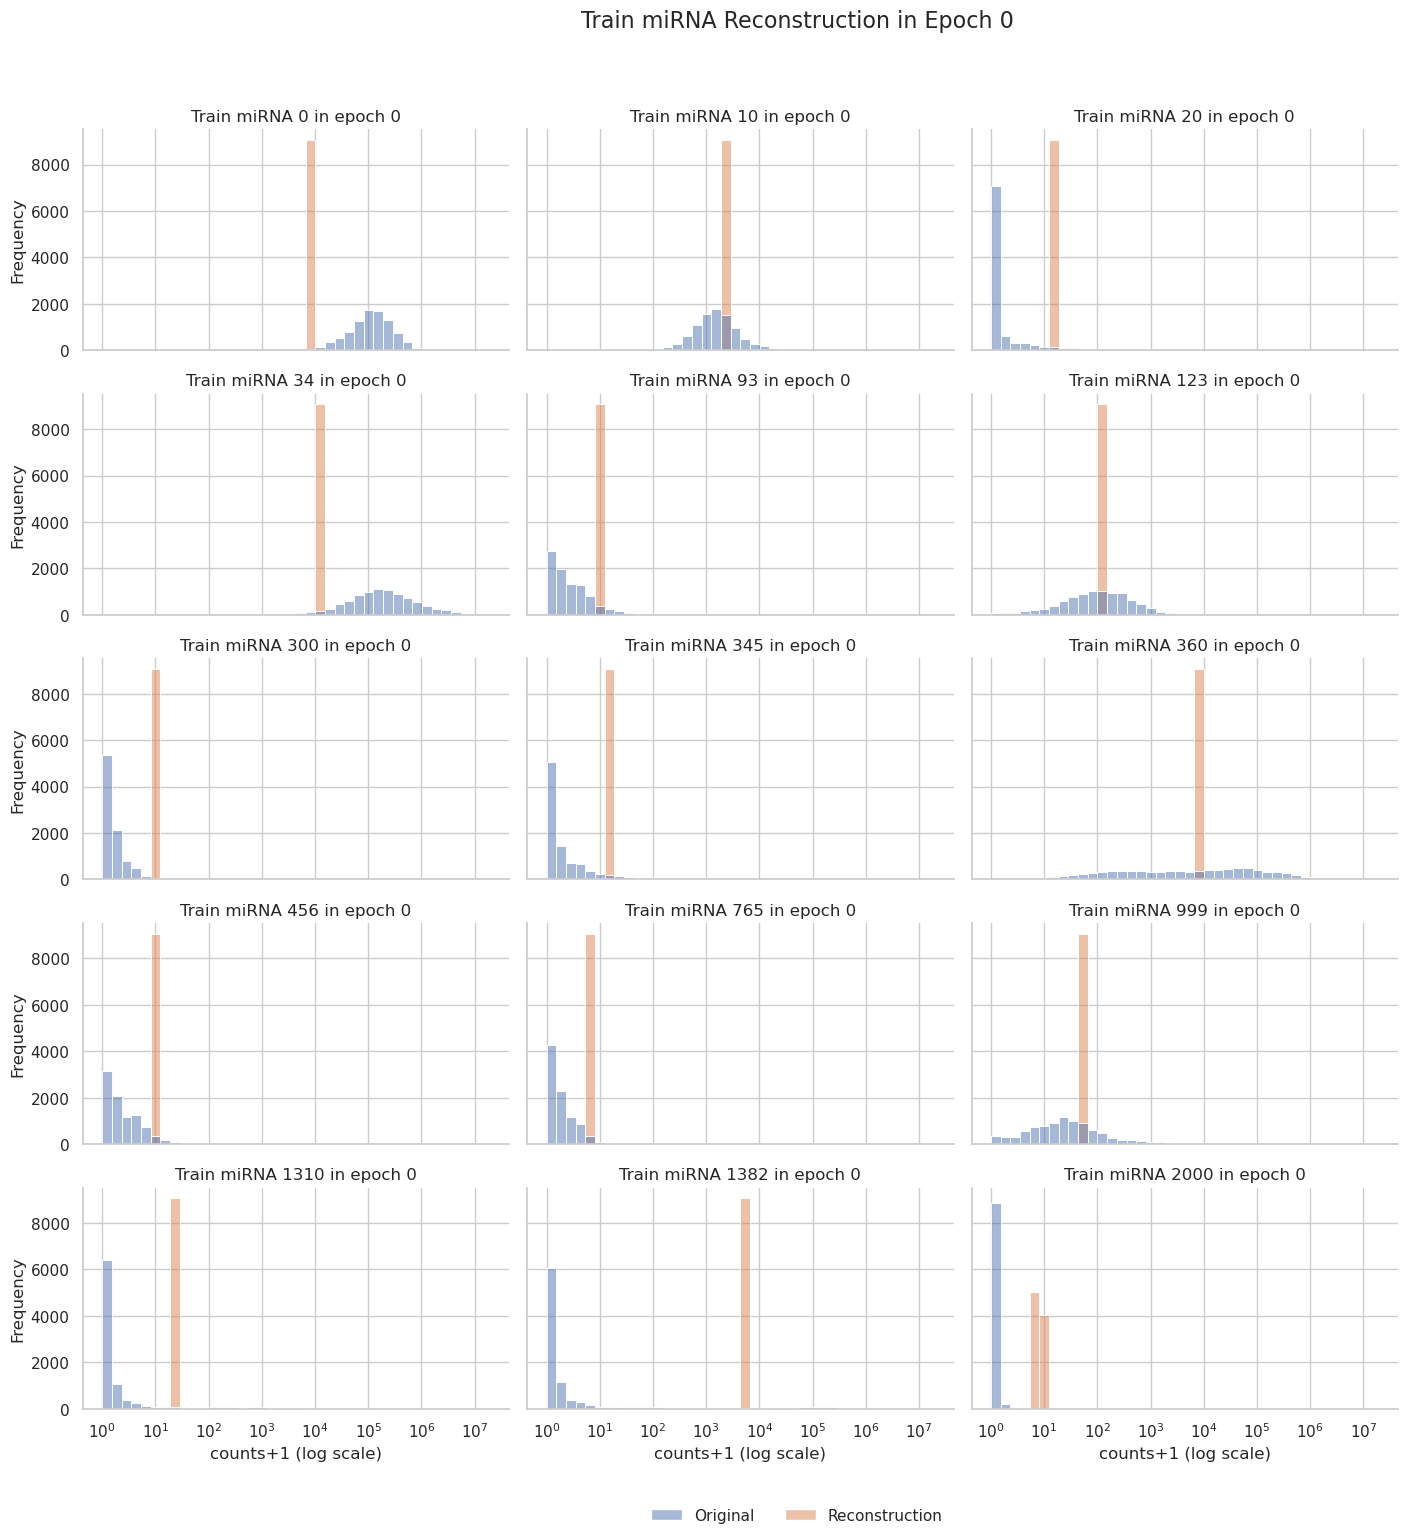

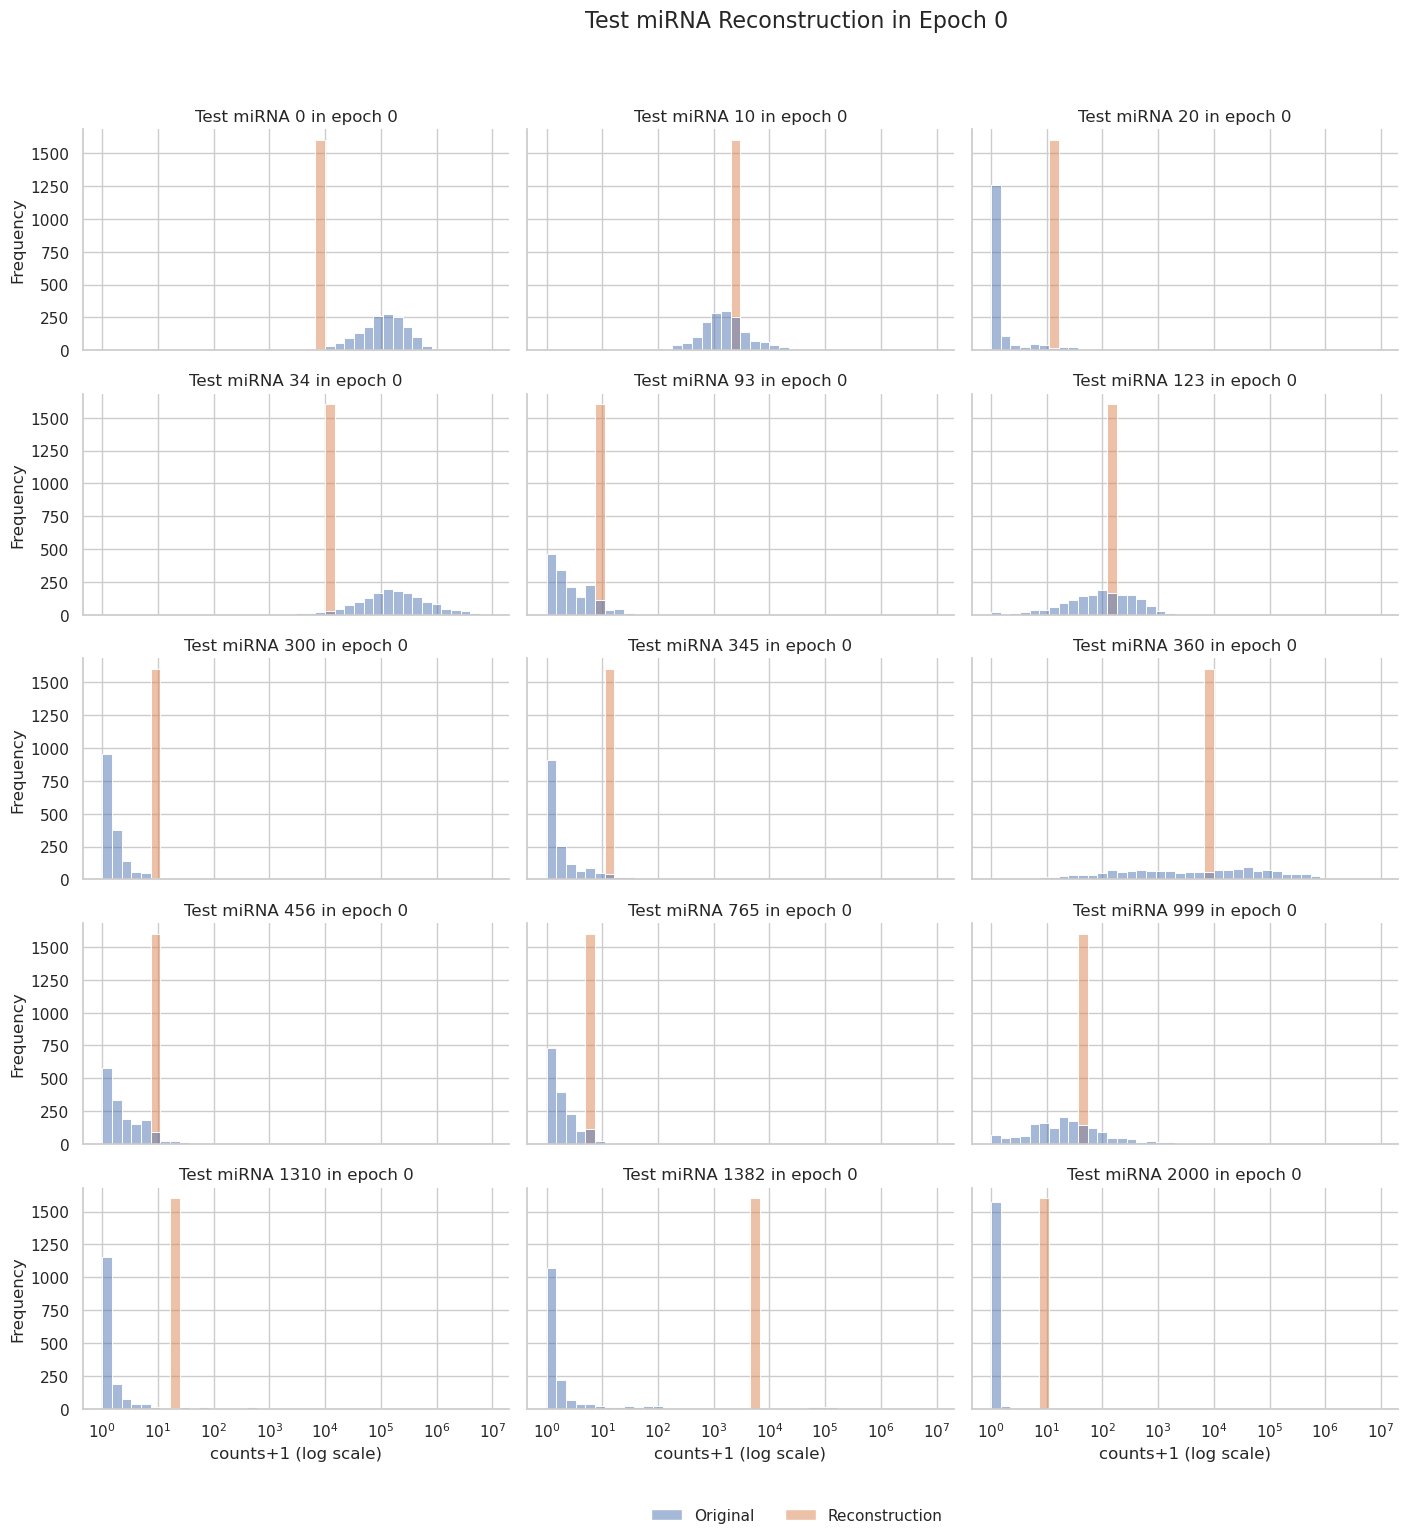

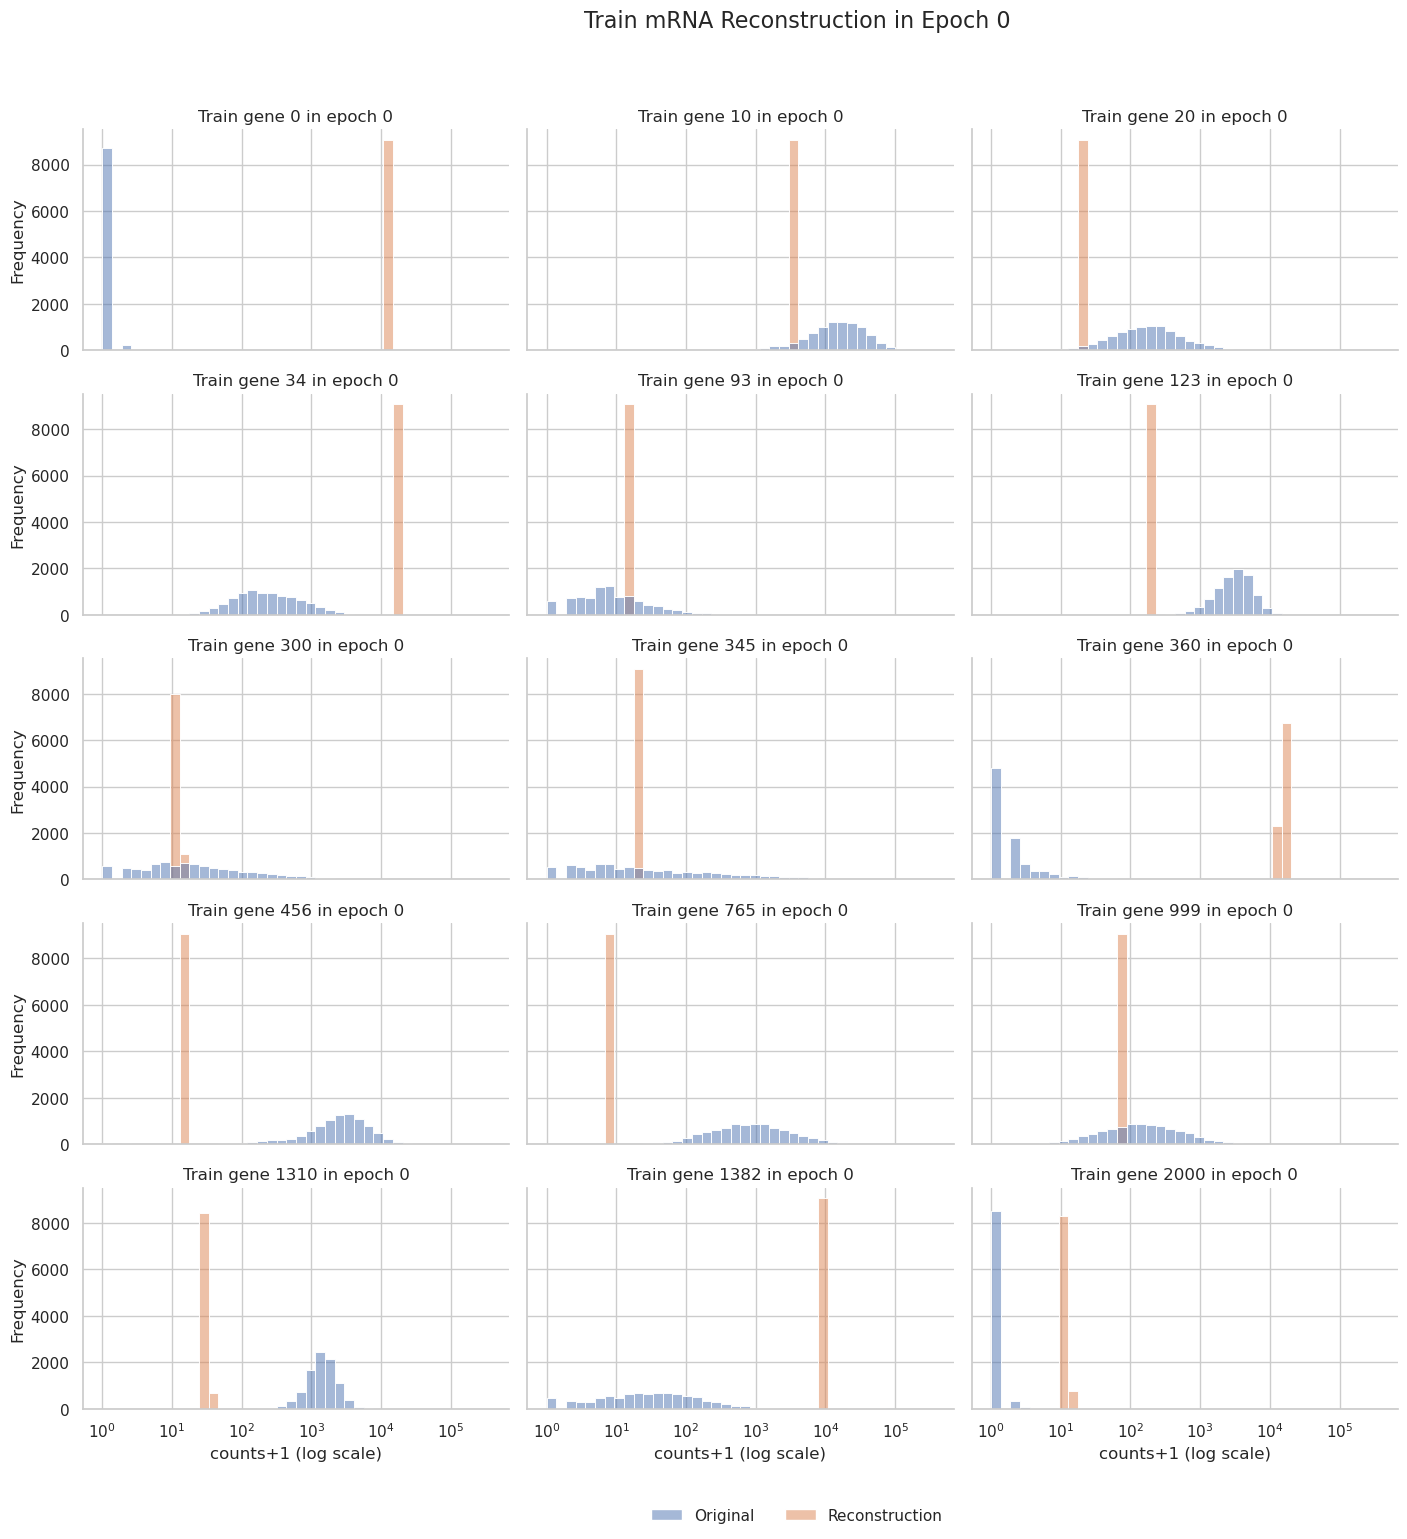

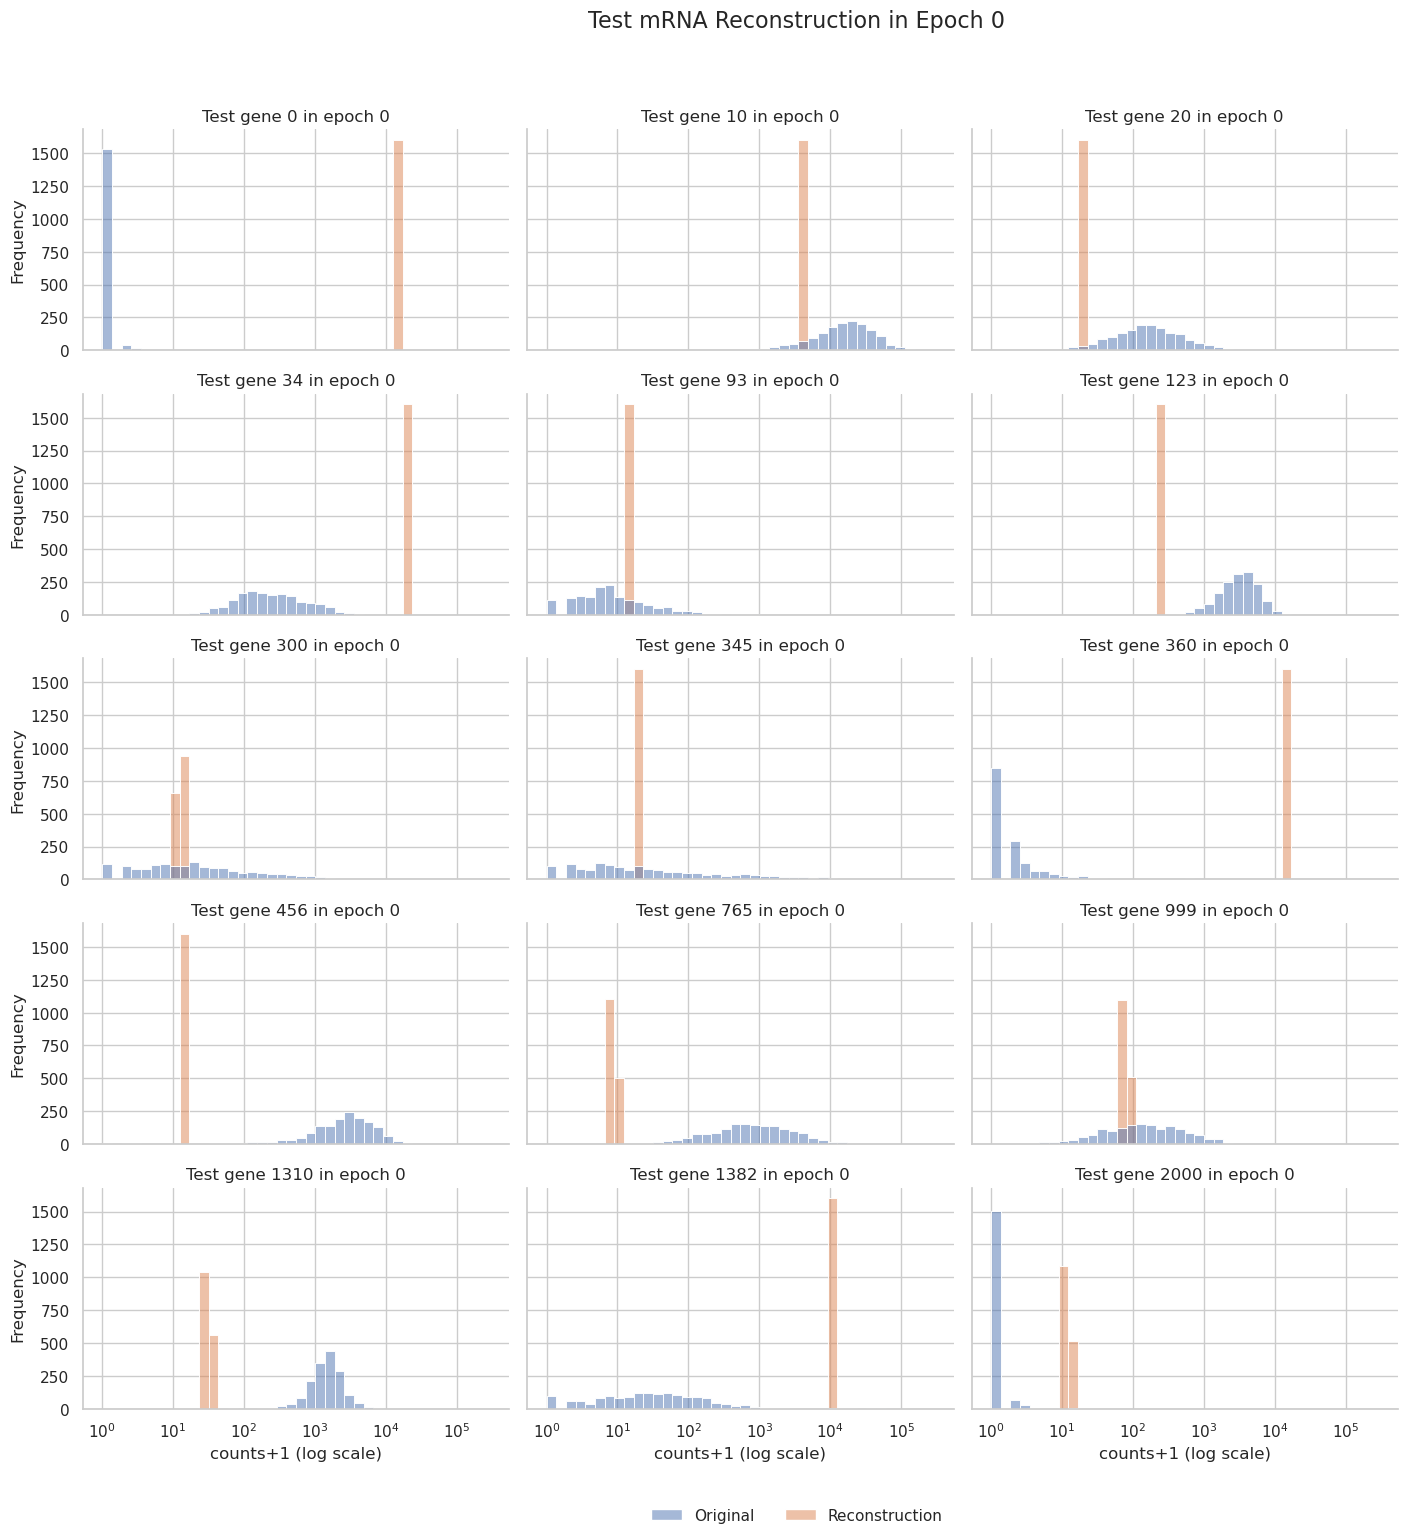

  6%|███████████████▉                                                                                                                                                                                                                                                             | 6/101 [01:47<14:25,  9.11s/it]

5 train_recon_mirna: 2.077872135795028 train_recon_mrna: 7.577625839783793 train_gmm: 2.1522692217289783 train_mse: 1001613.0625 train_mae: 176.853271484375 train_r2: 0.07450723648071289 train_spearman: 0.3903336226940155 train_pearson: 0.35330745577812195 train_expl_var: 0.07450723648071289 train_msle: 14.615443229675293
5 test_recon_mrna: 7.555140523900321 test_gmm: 2.1502120685934574 test_mse: 24116790.0 test_mae: 998.6502685546875 test_r2: 0.10708928108215332 test_spearman: 0.3782573640346527 test_pearson: 0.3883121609687805 test_expl_var: 0.10708928108215332 test_msle: 26.417551040649414


 11%|█████████████████████████████▏                                                                                                                                                                                                                                              | 11/101 [02:10<07:46,  5.18s/it]

10 train_recon_mirna: 1.9223457298943383 train_recon_mrna: 7.355864256384647 train_gmm: 2.1478268417146515 train_mse: 1008245.4375 train_mae: 155.5630340576172 train_r2: 0.06837886571884155 train_spearman: 0.33352166414260864 train_pearson: 0.27376365661621094 train_expl_var: 0.06837886571884155 train_msle: 4.616309642791748
10 test_recon_mrna: 7.38195564531396 test_gmm: 2.148357110374727 test_mse: 25541222.0 test_mae: 940.3695068359375 test_r2: 0.05435055494308472 test_spearman: 0.33445096015930176 test_pearson: 0.27075672149658203 test_expl_var: 0.05435049533843994 test_msle: 9.725981712341309


 16%|██████████████████████████████████████████▍                                                                                                                                                                                                                                 | 16/101 [02:32<06:29,  4.59s/it]

15 train_recon_mirna: 1.8593092762231629 train_recon_mrna: 7.1493406284010135 train_gmm: 2.150134223532724 train_mse: 1068582.5 train_mae: 161.3436737060547 train_r2: 0.01262730360031128 train_spearman: 0.3362390697002411 train_pearson: 0.19937647879123688 train_expl_var: 0.01262730360031128 train_msle: 3.7442984580993652
15 test_recon_mrna: 7.142579464963175 test_gmm: 2.150373145018922 test_mse: 27651262.0 test_mae: 964.2050170898438 test_r2: -0.023772597312927246 test_spearman: 0.34495794773101807 test_pearson: 0.19919168949127197 test_expl_var: -0.023772597312927246 test_msle: 7.587832450866699


 21%|███████████████████████████████████████████████████████▋                                                                                                                                                                                                                    | 21/101 [02:55<06:00,  4.51s/it]

20 train_recon_mirna: 1.7878430636085159 train_recon_mrna: 6.998506974286366 train_gmm: 2.150993722836194 train_mse: 938564.5625 train_mae: 143.7189483642578 train_r2: 0.13276416063308716 train_spearman: 0.3218249976634979 train_pearson: 0.36881810426712036 train_expl_var: 0.13276416063308716 train_msle: 4.158938407897949
20 test_recon_mrna: 6.991580984747634 test_gmm: 2.1511318706841056 test_mse: 22831596.0 test_mae: 878.51123046875 test_r2: 0.15467286109924316 test_spearman: 0.3235718607902527 test_pearson: 0.39415985345840454 test_expl_var: 0.15467286109924316 test_msle: 9.275348663330078


 26%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                       | 26/101 [03:17<05:37,  4.49s/it]

25 train_recon_mirna: 1.7381286603797348 train_recon_mrna: 6.87926063910333 train_gmm: 2.1521292942274974 train_mse: 901497.625 train_mae: 135.44091796875 train_r2: 0.16701406240463257 train_spearman: 0.32107797265052795 train_pearson: 0.41520214080810547 train_expl_var: 0.16701412200927734 train_msle: 4.017584800720215
25 test_recon_mrna: 6.880278133681463 test_gmm: 2.152195124441616 test_mse: 20888222.0 test_mae: 822.4942626953125 test_r2: 0.2266252040863037 test_spearman: 0.3186262547969818 test_pearson: 0.48178213834762573 test_expl_var: 0.2266252040863037 test_msle: 9.820653915405273


 31%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                         | 31/101 [03:39<05:12,  4.47s/it]

30 train_recon_mirna: 1.7044607040523947 train_recon_mrna: 6.791529474908247 train_gmm: 2.153836099255944 train_mse: 836327.8125 train_mae: 124.74179077148438 train_r2: 0.22723114490509033 train_spearman: 0.35235685110092163 train_pearson: 0.4899294674396515 train_expl_var: 0.22723114490509033 train_msle: 3.5136282444000244
30 test_recon_mrna: 6.795593281346154 test_gmm: 2.1543069941869537 test_mse: 18869706.0 test_mae: 759.1202392578125 test_r2: 0.3013596534729004 test_spearman: 0.3491760790348053 test_pearson: 0.5613061785697937 test_expl_var: 0.3013596534729004 test_msle: 9.195148468017578


 36%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 36/101 [04:02<04:51,  4.49s/it]

35 train_recon_mirna: 1.674446596690252 train_recon_mrna: 6.7230359092659615 train_gmm: 2.155558167781918 train_mse: 738541.0 train_mae: 111.23011779785156 train_r2: 0.31758636236190796 train_spearman: 0.3792001008987427 train_pearson: 0.581546425819397 train_expl_var: 0.31758642196655273 train_msle: 2.693891763687134
35 test_recon_mrna: 6.729382322844524 test_gmm: 2.155753474050991 test_mse: 16965624.0 test_mae: 671.6276245117188 test_r2: 0.371857225894928 test_spearman: 0.36285480856895447 test_pearson: 0.6161681413650513 test_expl_var: 0.371857225894928 test_msle: 7.075981140136719


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 41/101 [04:24<04:29,  4.49s/it]

40 train_recon_mirna: 1.6469600082428828 train_recon_mrna: 6.659891685838531 train_gmm: 2.1576226277947295 train_mse: 684241.5 train_mae: 101.59876251220703 train_r2: 0.3677592873573303 train_spearman: 0.38855379819869995 train_pearson: 0.6147623658180237 train_expl_var: 0.3677592873573303 train_msle: 2.026365280151367
40 test_recon_mrna: 6.658723136213175 test_gmm: 2.157658906286575 test_mse: 15092609.0 test_mae: 595.989013671875 test_r2: 0.4412045478820801 test_spearman: 0.3658926784992218 test_pearson: 0.6661657691001892 test_expl_var: 0.4412045478820801 test_msle: 6.265382289886475


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 46/101 [04:46<04:05,  4.47s/it]

45 train_recon_mirna: 1.6285532925424964 train_recon_mrna: 6.602831552777936 train_gmm: 2.159982198236376 train_mse: 664614.8125 train_mae: 96.55667877197266 train_r2: 0.3858943581581116 train_spearman: 0.40002208948135376 train_pearson: 0.6251828670501709 train_expl_var: 0.3858943581581116 train_msle: 1.72726571559906
45 test_recon_mrna: 6.610878890267069 test_gmm: 2.1601505046182505 test_mse: 13627500.0 test_mae: 546.988037109375 test_r2: 0.495449423789978 test_spearman: 0.36609435081481934 test_pearson: 0.7045965790748596 test_expl_var: 0.495449423789978 test_msle: 5.901417255401611


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 50/101 [05:04<03:47,  4.46s/it]

50 train_recon_mirna: 1.614043822785892 train_recon_mrna: 6.555341594889341 train_gmm: 2.162083088313795 train_mse: 686469.75 train_mae: 97.25682067871094 train_r2: 0.365700364112854 train_spearman: 0.4145698845386505 train_pearson: 0.6055419445037842 train_expl_var: 0.365700364112854 train_msle: 1.377261757850647
50 test_recon_mrna: 6.578573184651414 test_gmm: 2.1629574512572174 test_mse: 15630724.0 test_mae: 582.0736694335938 test_r2: 0.4212811589241028 test_spearman: 0.37640082836151123 test_pearson: 0.6492224335670471 test_expl_var: 0.4212811589241028 test_msle: 4.46232271194458


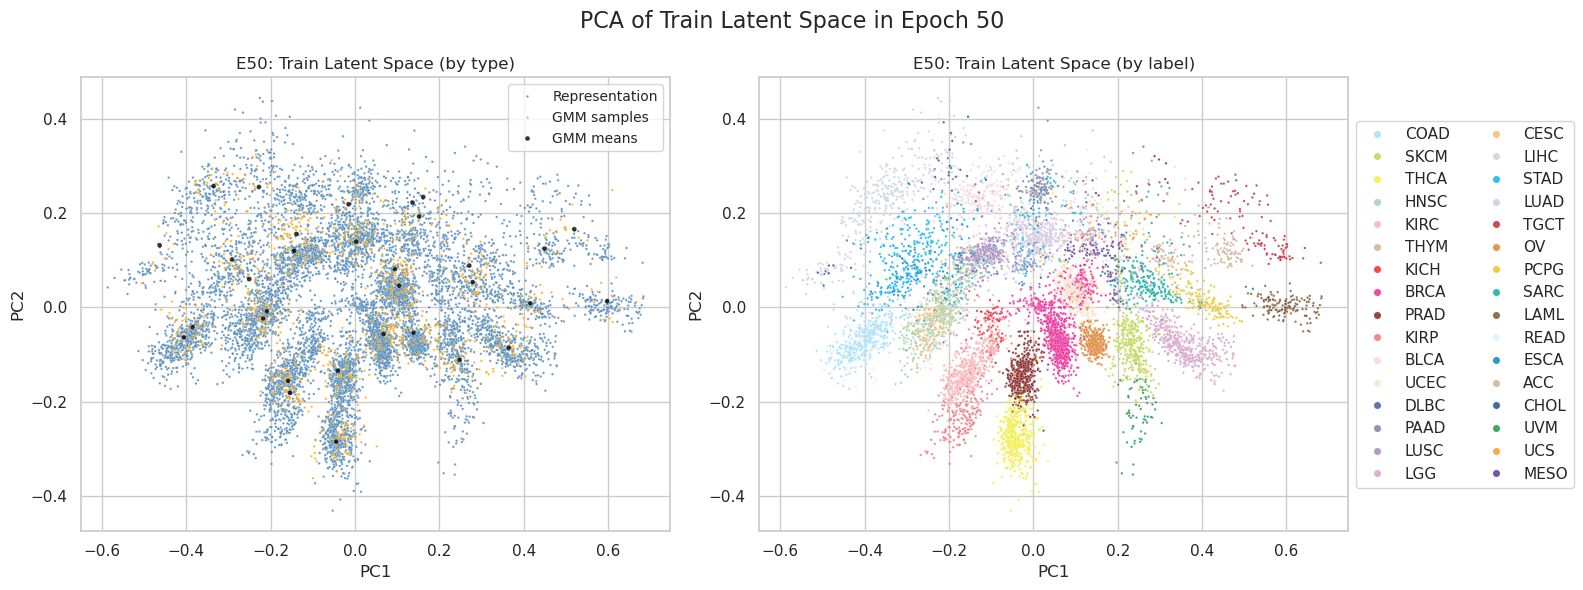

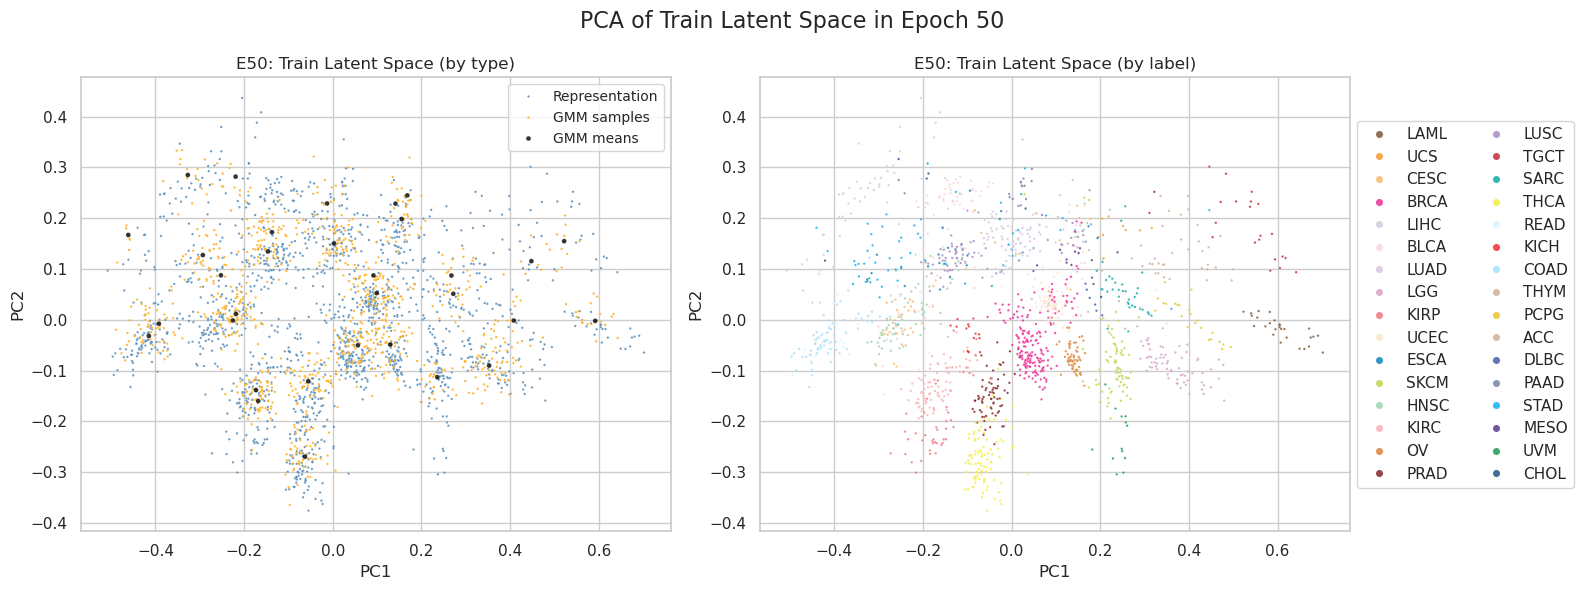

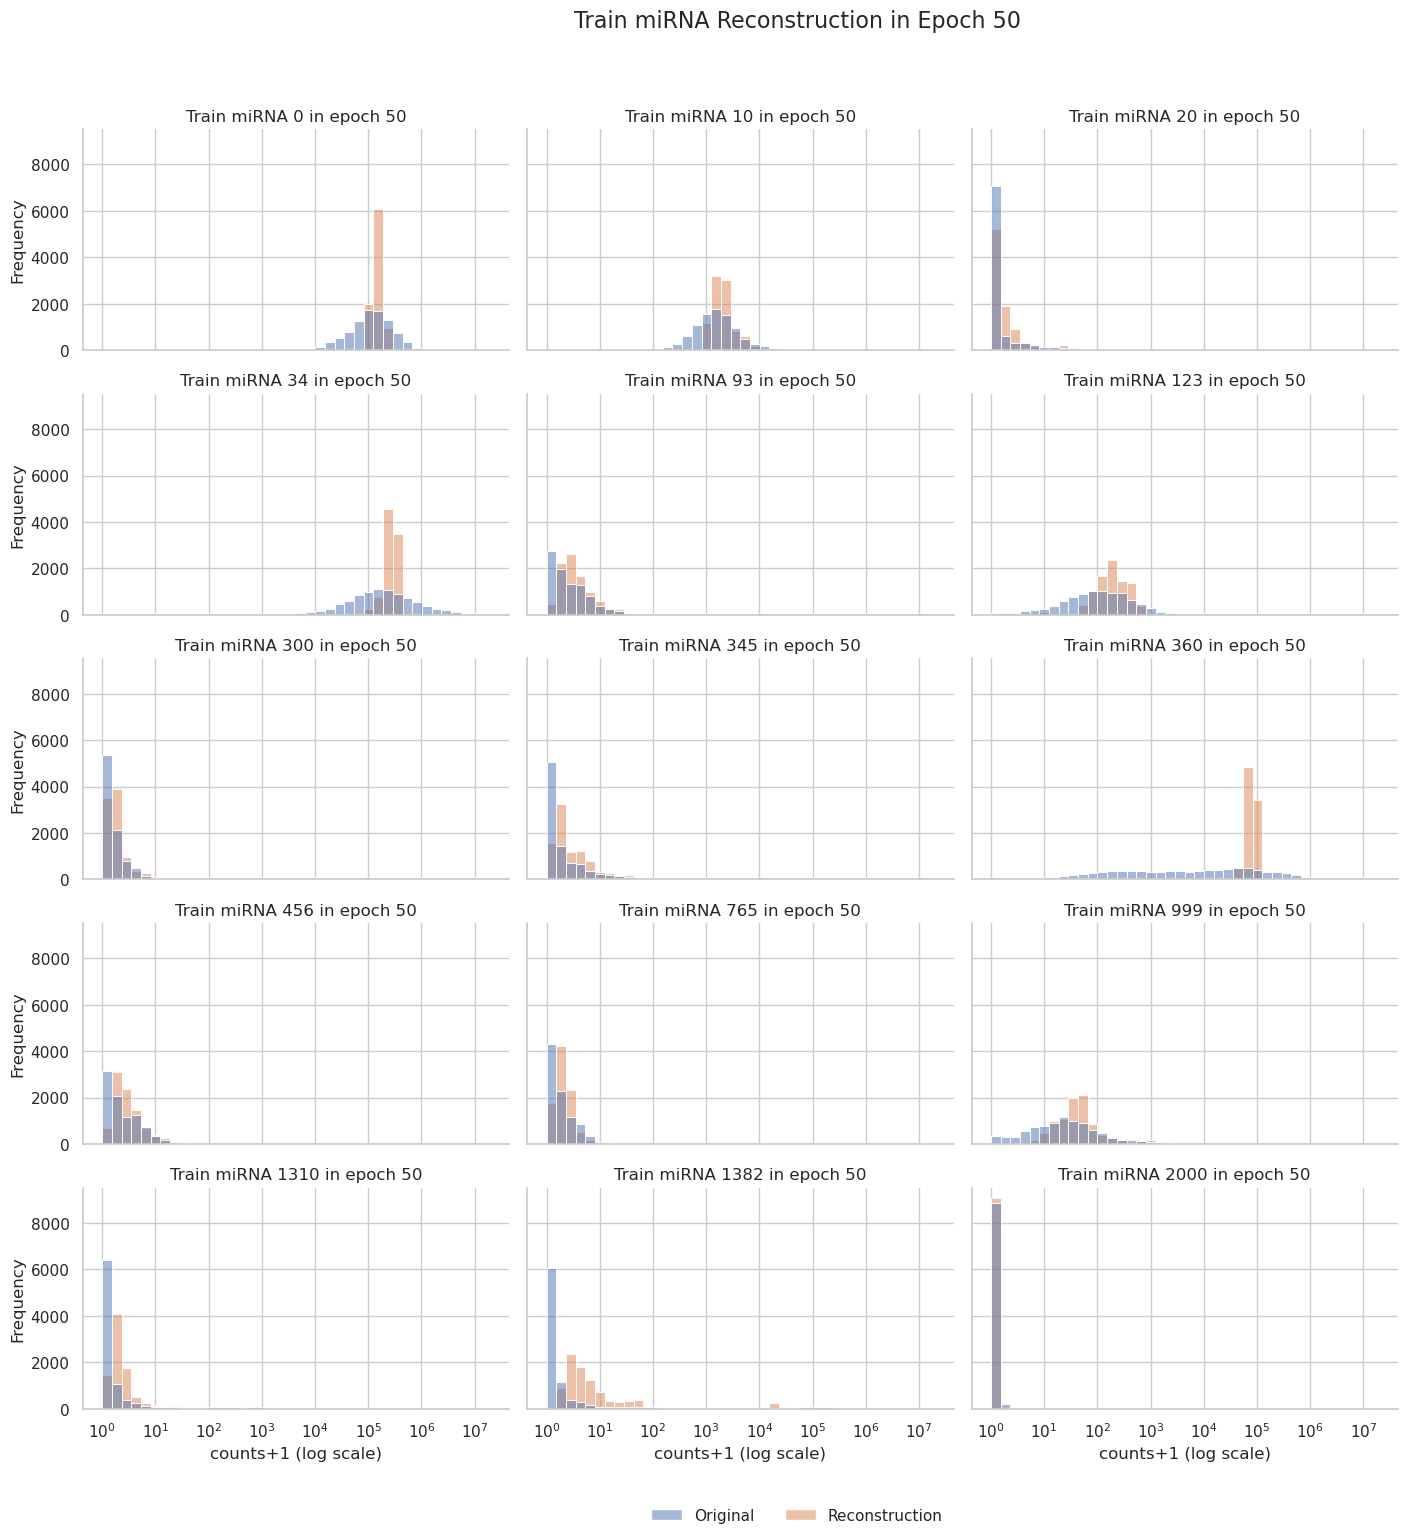

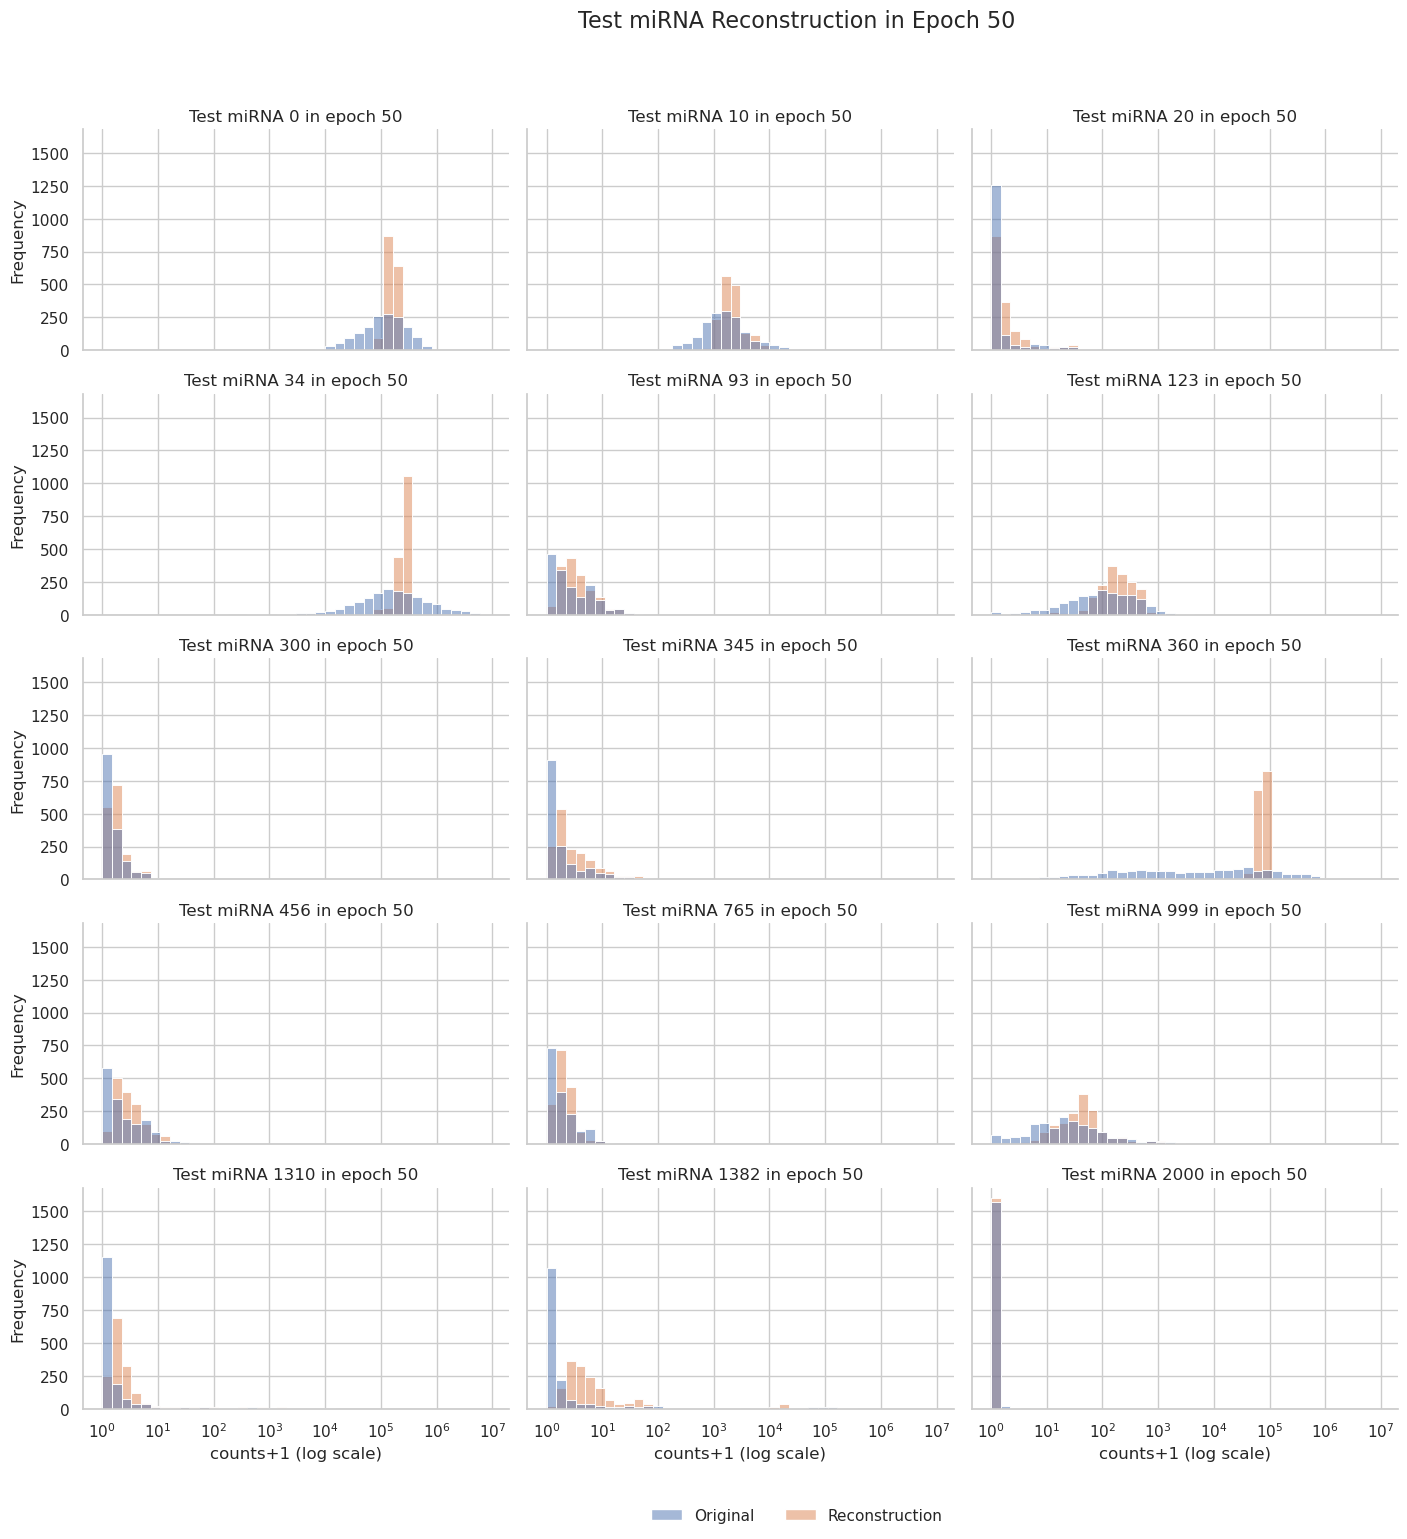

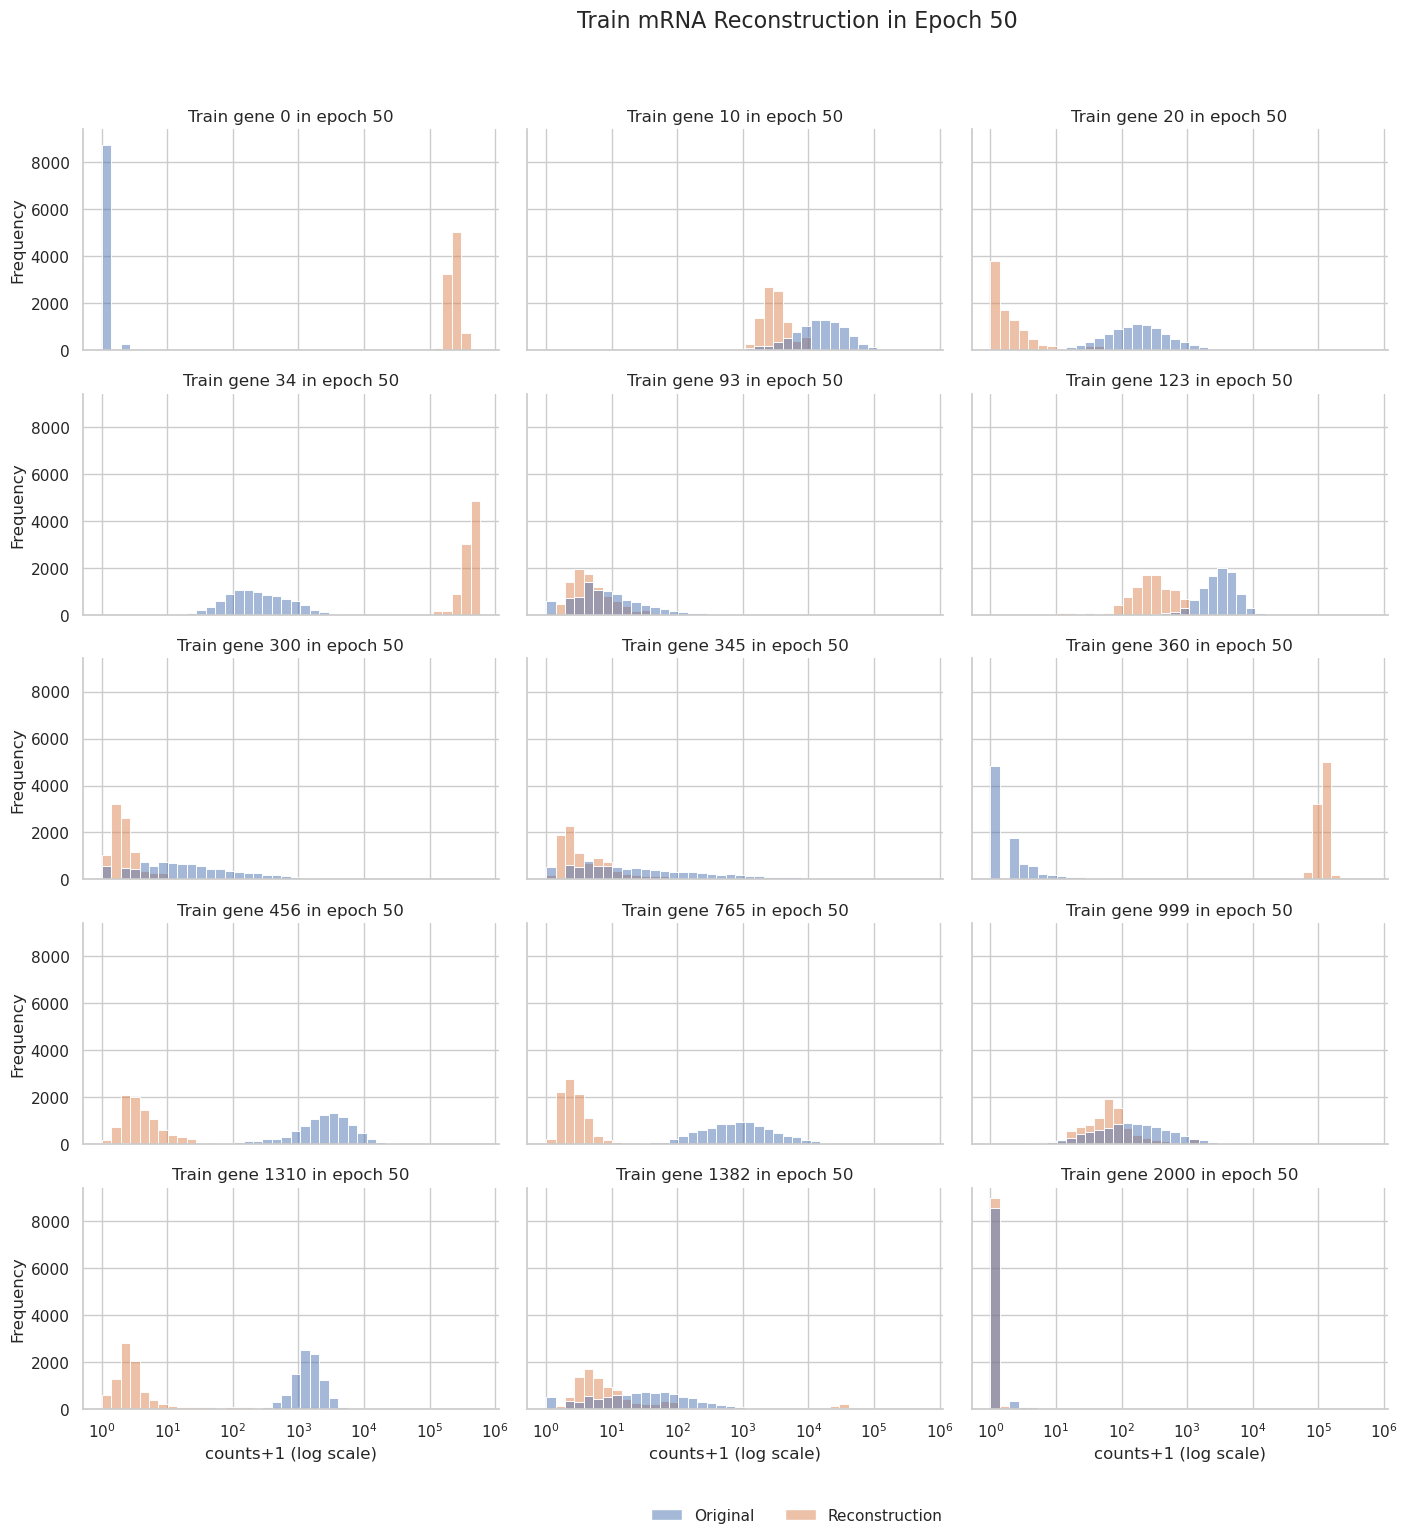

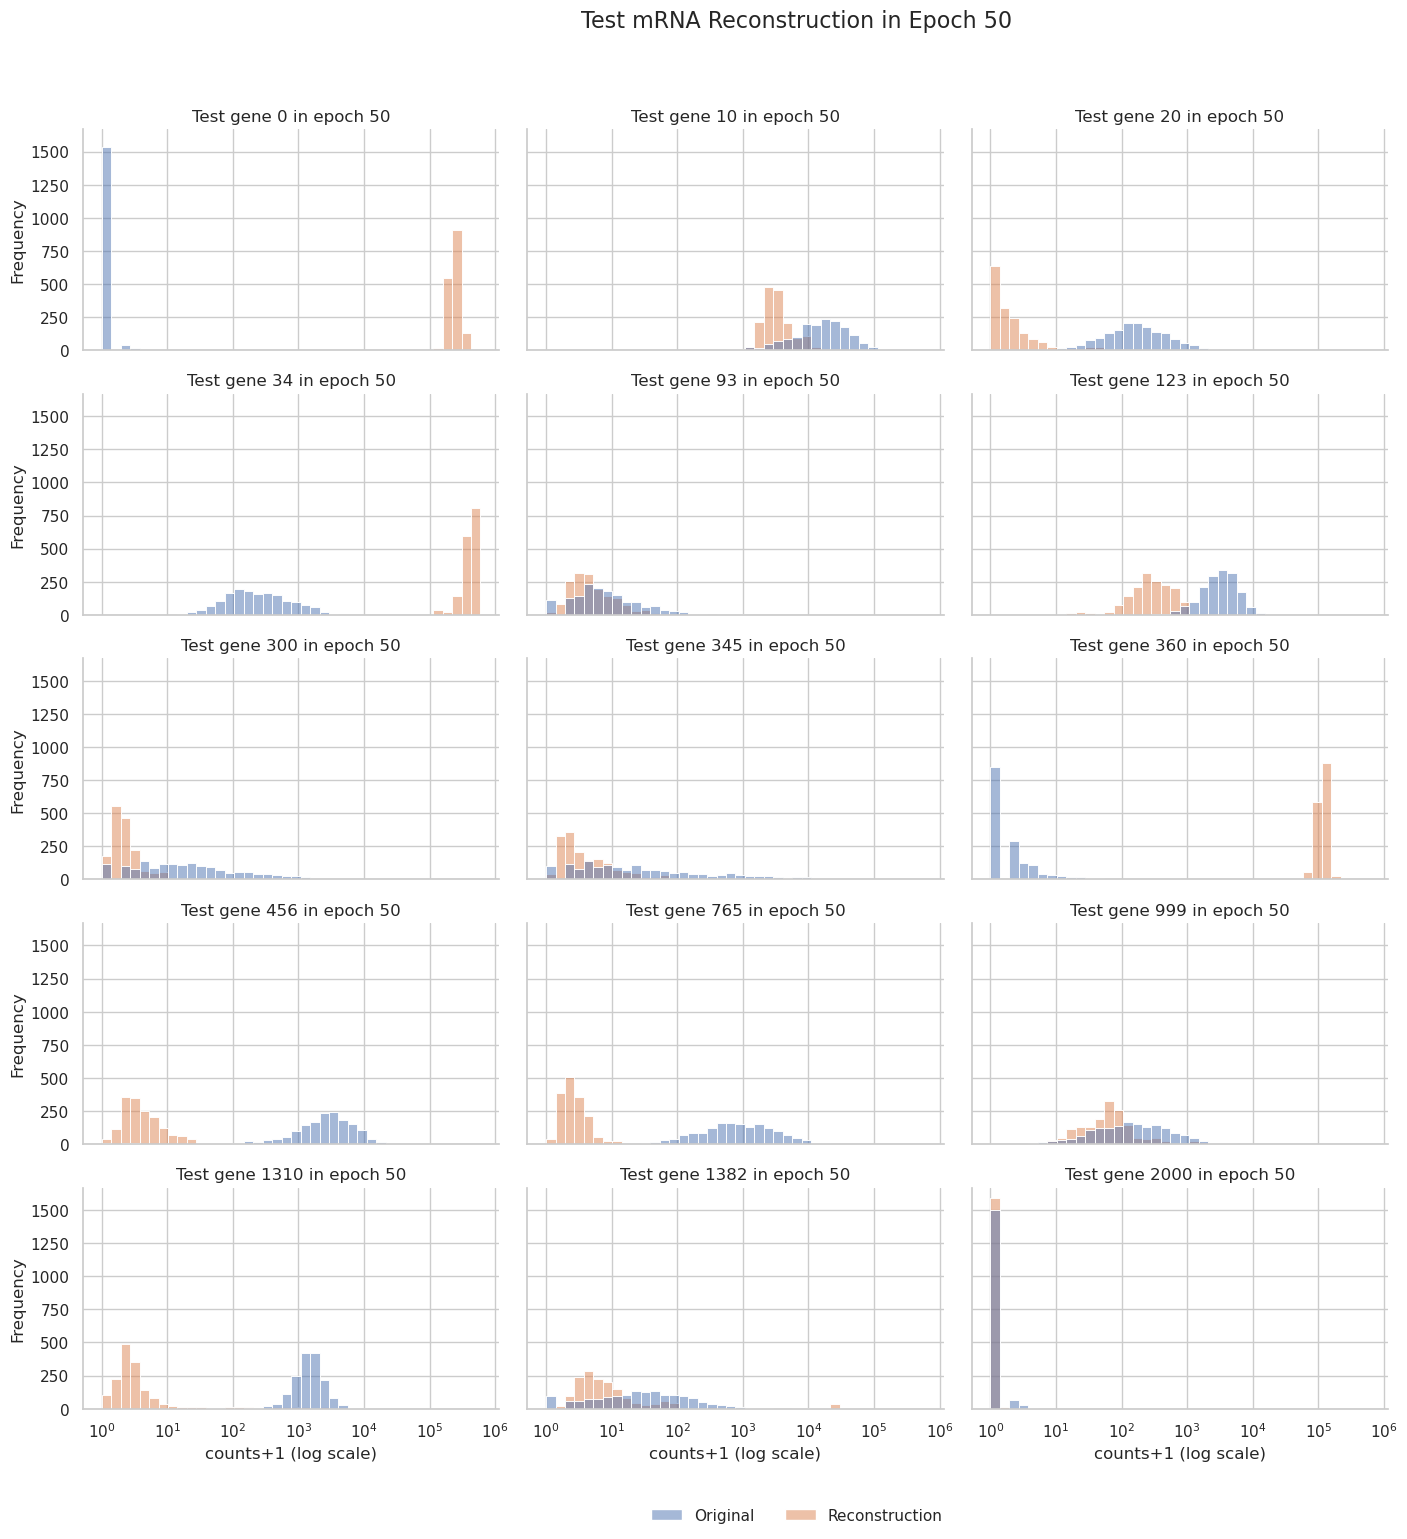

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 56/101 [07:04<06:51,  9.14s/it]

55 train_recon_mirna: 1.603456274205737 train_recon_mrna: 6.516479939484854 train_gmm: 2.1641122967234683 train_mse: 705483.5 train_mae: 100.71336364746094 train_r2: 0.34813159704208374 train_spearman: 0.42455753684043884 train_pearson: 0.5900989174842834 train_expl_var: 0.34813159704208374 train_msle: 1.1325047016143799
55 test_recon_mrna: 6.531784691648581 test_gmm: 2.1650504618250626 test_mse: 16521451.0 test_mae: 604.3712158203125 test_r2: 0.3883025050163269 test_spearman: 0.3822106719017029 test_pearson: 0.6241376996040344 test_expl_var: 0.38830244541168213 test_msle: 4.164848804473877


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 61/101 [07:26<03:29,  5.25s/it]

60 train_recon_mirna: 1.5950051616414695 train_recon_mrna: 6.484039250531261 train_gmm: 2.166416468713839 train_mse: 727695.625 train_mae: 102.88063049316406 train_r2: 0.32760751247406006 train_spearman: 0.43277424573898315 train_pearson: 0.5727397203445435 train_expl_var: 0.32760757207870483 train_msle: 1.0495957136154175
60 test_recon_mrna: 6.492051231956819 test_gmm: 2.167024663384636 test_mse: 15562629.0 test_mae: 574.8724365234375 test_r2: 0.42380231618881226 test_spearman: 0.38961151242256165 test_pearson: 0.6525189280509949 test_expl_var: 0.42380231618881226 test_msle: 3.6131324768066406


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 66/101 [07:48<02:40,  4.57s/it]

65 train_recon_mirna: 1.587521686765956 train_recon_mrna: 6.456518642467144 train_gmm: 2.1689929998312487 train_mse: 708403.9375 train_mae: 101.3487319946289 train_r2: 0.3454331159591675 train_spearman: 0.4248259961605072 train_pearson: 0.5877444744110107 train_expl_var: 0.3454331159591675 train_msle: 1.0677385330200195
65 test_recon_mrna: 6.481990358543935 test_gmm: 2.1695641068781213 test_mse: 16323963.0 test_mae: 584.7904663085938 test_r2: 0.3956143856048584 test_spearman: 0.3809809386730194 test_pearson: 0.6335859298706055 test_expl_var: 0.3956143856048584 test_msle: 3.623638391494751


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 71/101 [08:11<02:14,  4.47s/it]

70 train_recon_mirna: 1.5804310504783796 train_recon_mrna: 6.433365391411284 train_gmm: 2.1717030145797747 train_mse: 719460.0625 train_mae: 102.3335189819336 train_r2: 0.3352172374725342 train_spearman: 0.42695102095603943 train_pearson: 0.5792826414108276 train_expl_var: 0.3352172374725342 train_msle: 0.9700652360916138
70 test_recon_mrna: 6.450479315180731 test_gmm: 2.1728229498892984 test_mse: 15943386.0 test_mae: 586.0901489257812 test_r2: 0.4097050428390503 test_spearman: 0.39260953664779663 test_pearson: 0.6421905755996704 test_expl_var: 0.4097049832344055 test_msle: 3.4333672523498535


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 76/101 [08:33<01:51,  4.45s/it]

75 train_recon_mirna: 1.574267380056497 train_recon_mrna: 6.413622612422227 train_gmm: 2.1745119555185144 train_mse: 721239.625 train_mae: 102.10304260253906 train_r2: 0.3335729241371155 train_spearman: 0.42998236417770386 train_pearson: 0.5779440402984619 train_expl_var: 0.3335729241371155 train_msle: 0.8834861516952515
75 test_recon_mrna: 6.444868152829586 test_gmm: 2.175708099250936 test_mse: 16453785.0 test_mae: 587.788818359375 test_r2: 0.3908078074455261 test_spearman: 0.3888845145702362 test_pearson: 0.62929368019104 test_expl_var: 0.39080774784088135 test_msle: 3.3363986015319824


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 81/101 [08:55<01:29,  4.46s/it]

80 train_recon_mirna: 1.5694117865352004 train_recon_mrna: 6.396749117936799 train_gmm: 2.177334069396421 train_mse: 702285.125 train_mae: 100.38655853271484 train_r2: 0.35108691453933716 train_spearman: 0.426237553358078 train_pearson: 0.5925434827804565 train_expl_var: 0.35108691453933716 train_msle: 0.9514456391334534
80 test_recon_mrna: 6.4291013356232325 test_gmm: 2.1785551264044942 test_mse: 14399219.0 test_mae: 551.8988647460938 test_r2: 0.46687692403793335 test_spearman: 0.38827866315841675 test_pearson: 0.6840766072273254 test_expl_var: 0.46687692403793335 test_msle: 3.3408772945404053


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 86/101 [09:17<01:06,  4.45s/it]

85 train_recon_mirna: 1.5643608111086622 train_recon_mrna: 6.3811863073809 train_gmm: 2.1801562774436234 train_mse: 691830.125 train_mae: 98.92697143554688 train_r2: 0.3607473373413086 train_spearman: 0.43836143612861633 train_pearson: 0.6006386280059814 train_expl_var: 0.3607473373413086 train_msle: 0.9078471064567566
85 test_recon_mrna: 6.397279949295084 test_gmm: 2.181704944320088 test_mse: 14650435.0 test_mae: 564.4712524414062 test_r2: 0.45757579803466797 test_spearman: 0.3909580707550049 test_pearson: 0.6764590740203857 test_expl_var: 0.45757579803466797 test_msle: 3.170732021331787


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 91/101 [09:40<00:44,  4.44s/it]

90 train_recon_mirna: 1.559641205473814 train_recon_mrna: 6.36875770443336 train_gmm: 2.183015308375923 train_mse: 676290.9375 train_mae: 97.2866439819336 train_r2: 0.375105619430542 train_spearman: 0.44252902269363403 train_pearson: 0.6127927899360657 train_expl_var: 0.375105619430542 train_msle: 0.8512580394744873
90 test_recon_mrna: 6.40394629665809 test_gmm: 2.184574023376541 test_mse: 14097821.0 test_mae: 561.9846801757812 test_r2: 0.4780360460281372 test_spearman: 0.3995790183544159 test_pearson: 0.6915423274040222 test_expl_var: 0.4780360460281372 test_msle: 3.0859155654907227


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 96/101 [10:02<00:22,  4.44s/it]

95 train_recon_mirna: 1.5558465851074836 train_recon_mrna: 6.35779281570474 train_gmm: 2.185715803953948 train_mse: 656635.0625 train_mae: 95.2713623046875 train_r2: 0.3932676315307617 train_spearman: 0.45009833574295044 train_pearson: 0.6279454827308655 train_expl_var: 0.3932676911354065 train_msle: 0.8160747289657593
95 test_recon_mrna: 6.419210526116515 test_gmm: 2.188030510567845 test_mse: 14646907.0 test_mae: 567.0005493164062 test_r2: 0.4577064514160156 test_spearman: 0.404316246509552 test_pearson: 0.6765401363372803 test_expl_var: 0.4577064514160156 test_msle: 2.687800407409668


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 100/101 [10:20<00:04,  4.44s/it]

100 train_recon_mirna: 1.5513276973231436 train_recon_mrna: 6.348311421719124 train_gmm: 2.188388344703962 train_mse: 677584.375 train_mae: 97.70903778076172 train_r2: 0.37391048669815063 train_spearman: 0.4466000497341156 train_pearson: 0.6131649613380432 train_expl_var: 0.37391048669815063 train_msle: 0.8629109859466553
100 test_recon_mrna: 6.377571309468098 test_gmm: 2.19065389454588 test_mse: 13891083.0 test_mae: 554.02001953125 test_r2: 0.4856904149055481 test_spearman: 0.40570905804634094 test_pearson: 0.6972185969352722 test_expl_var: 0.4856904149055481 test_msle: 2.8426828384399414


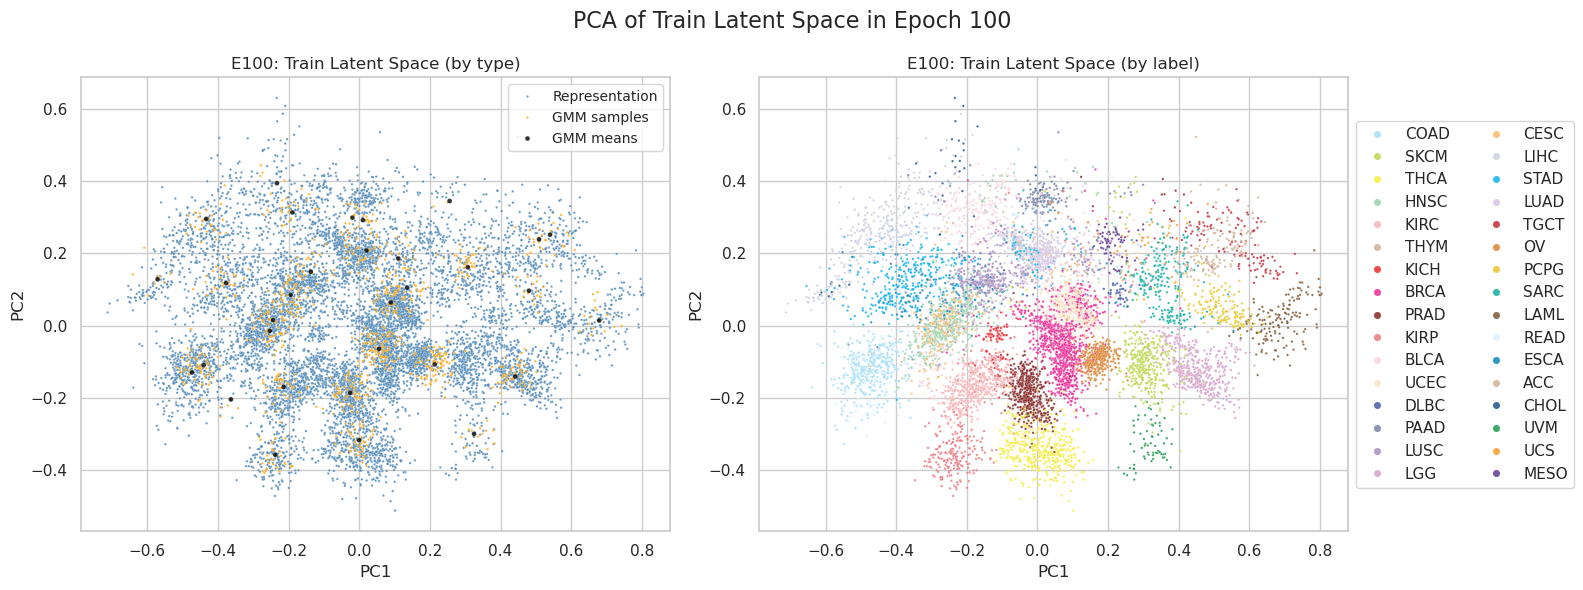

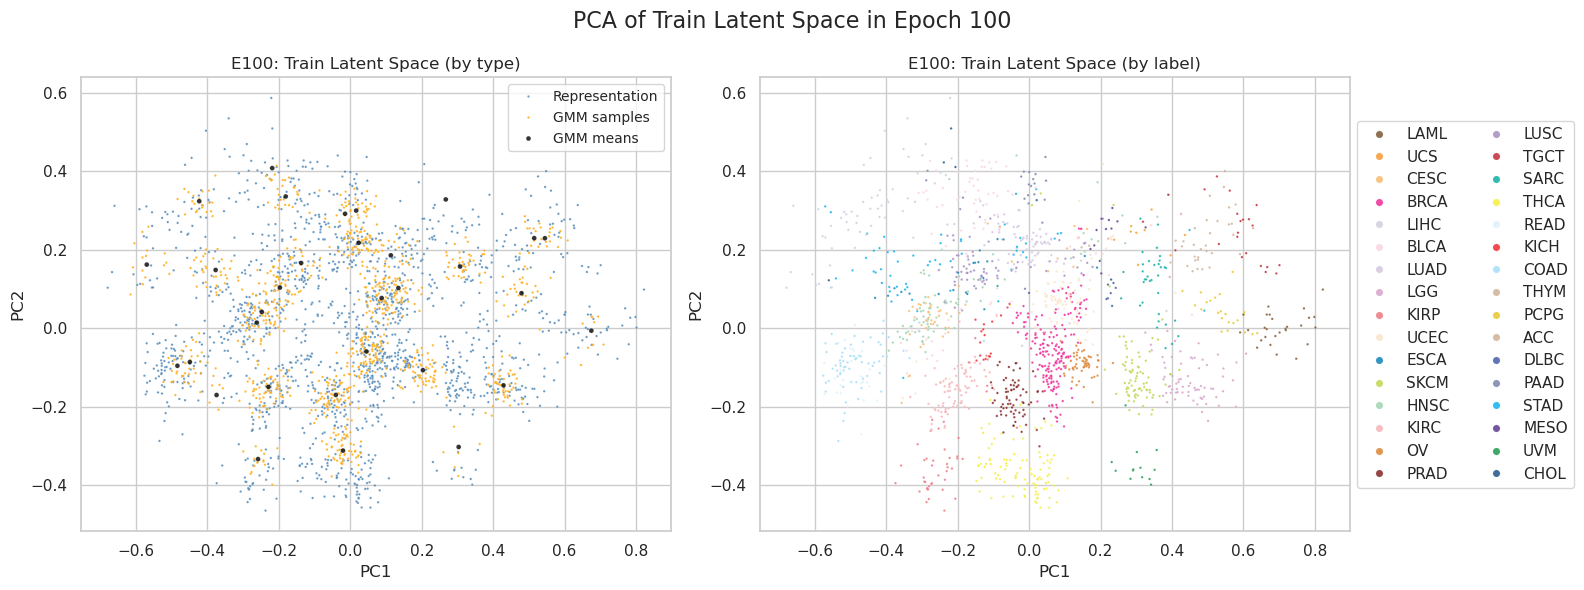

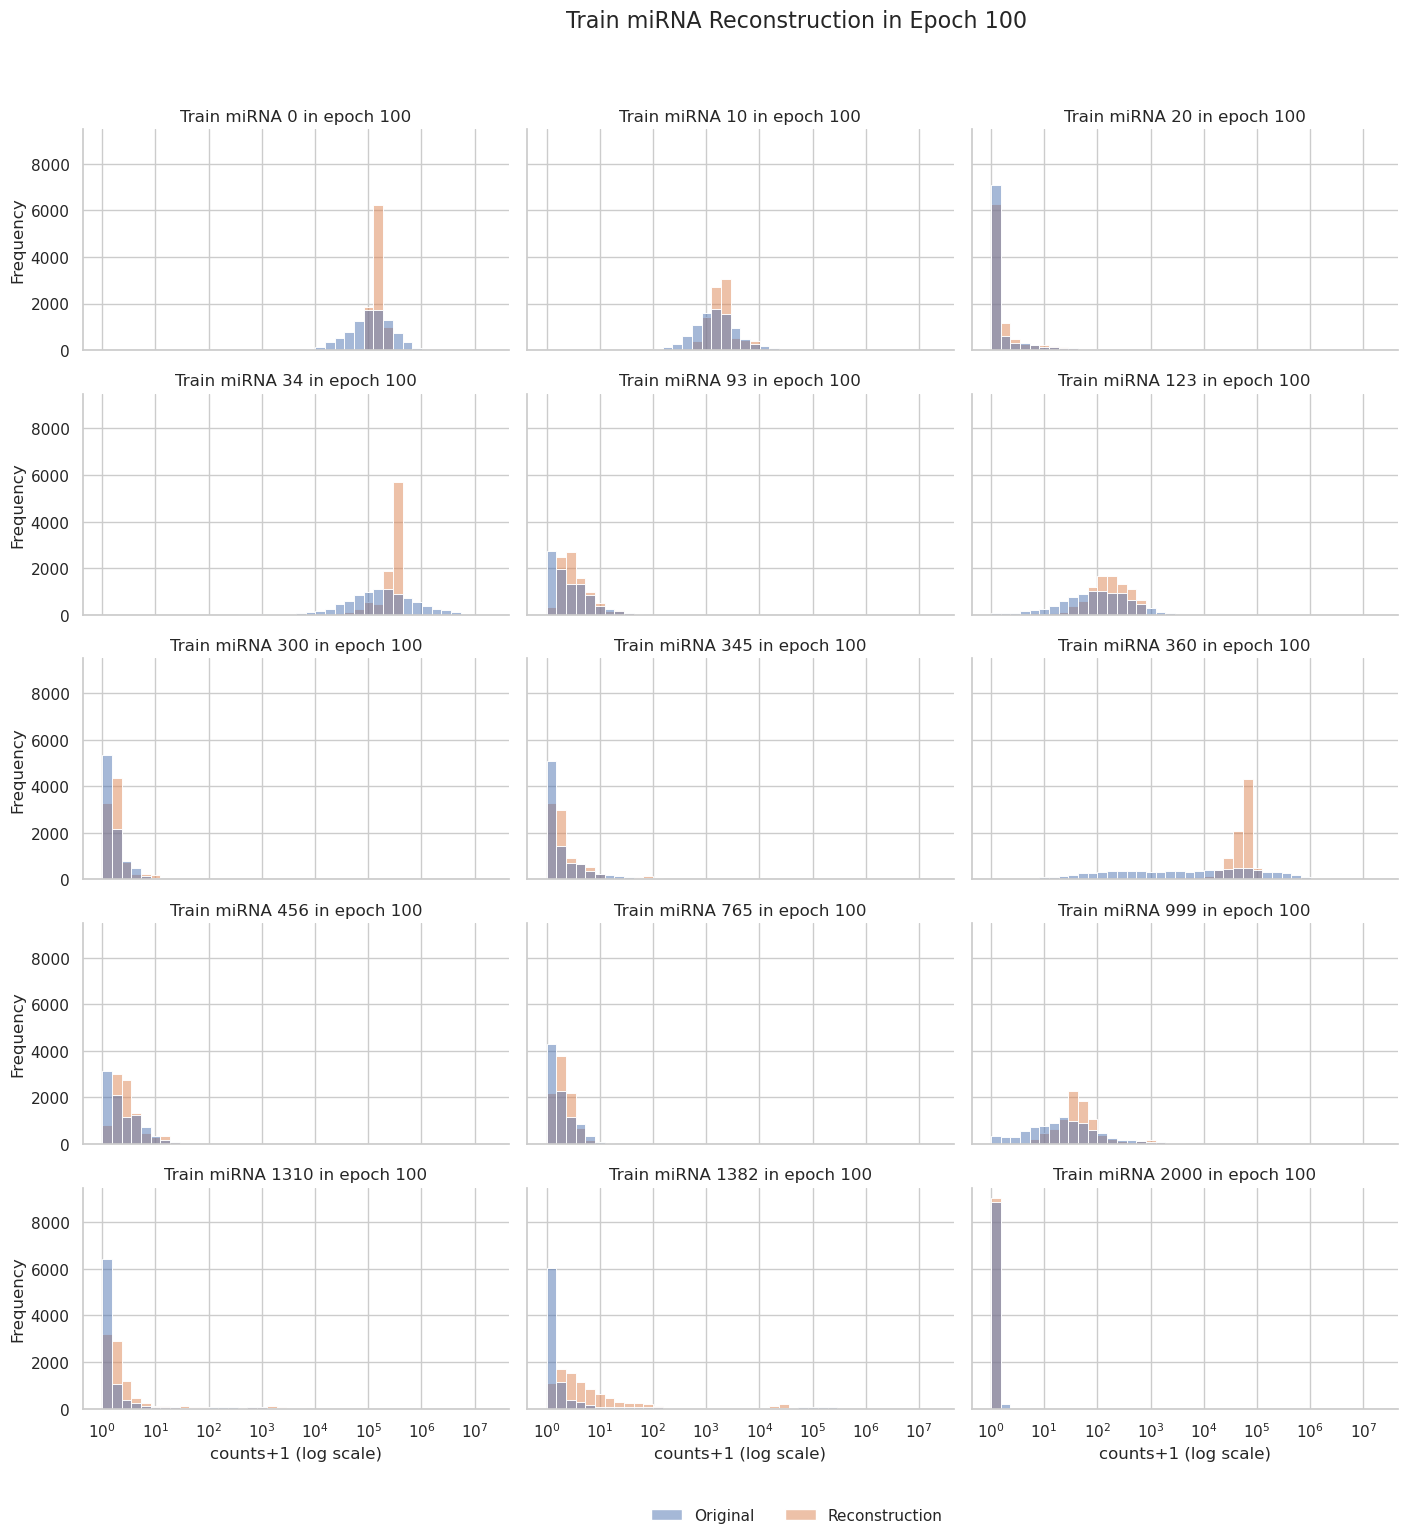

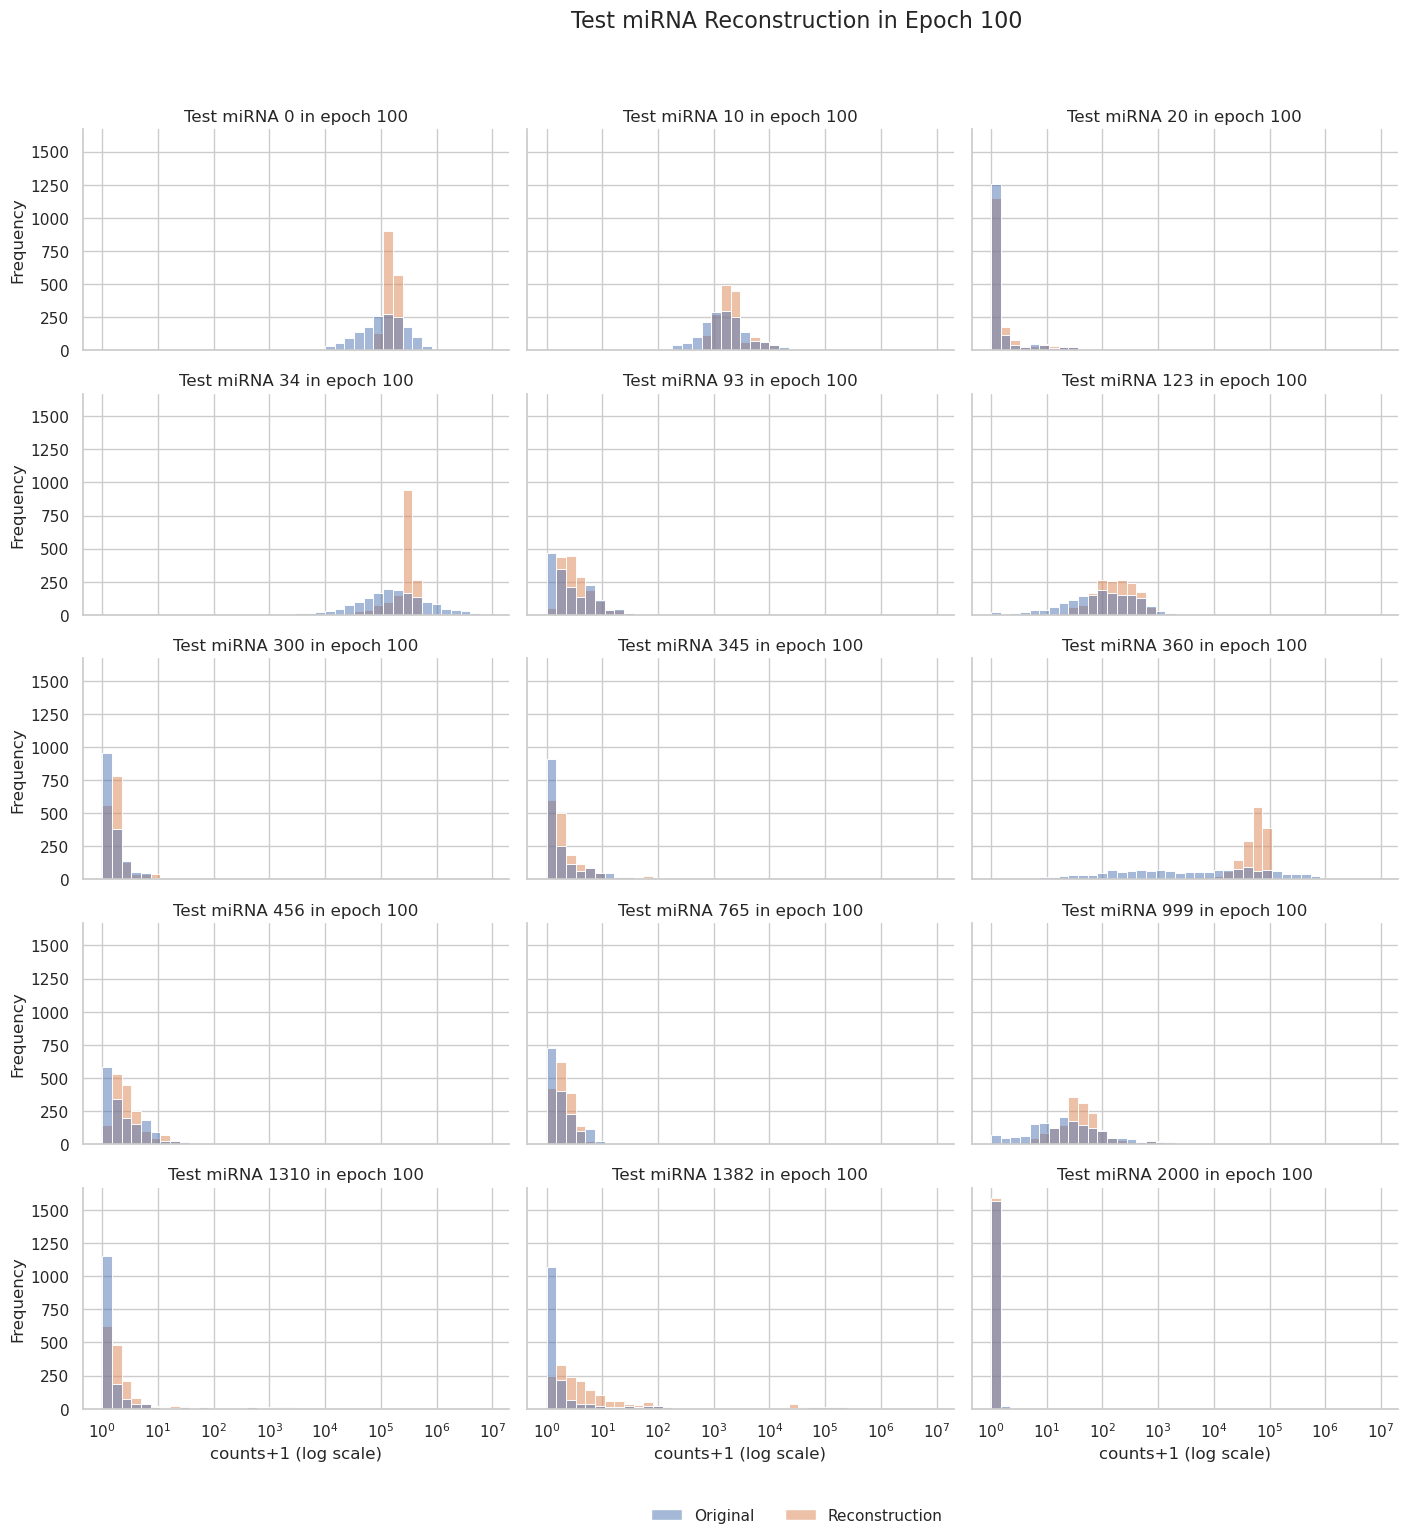

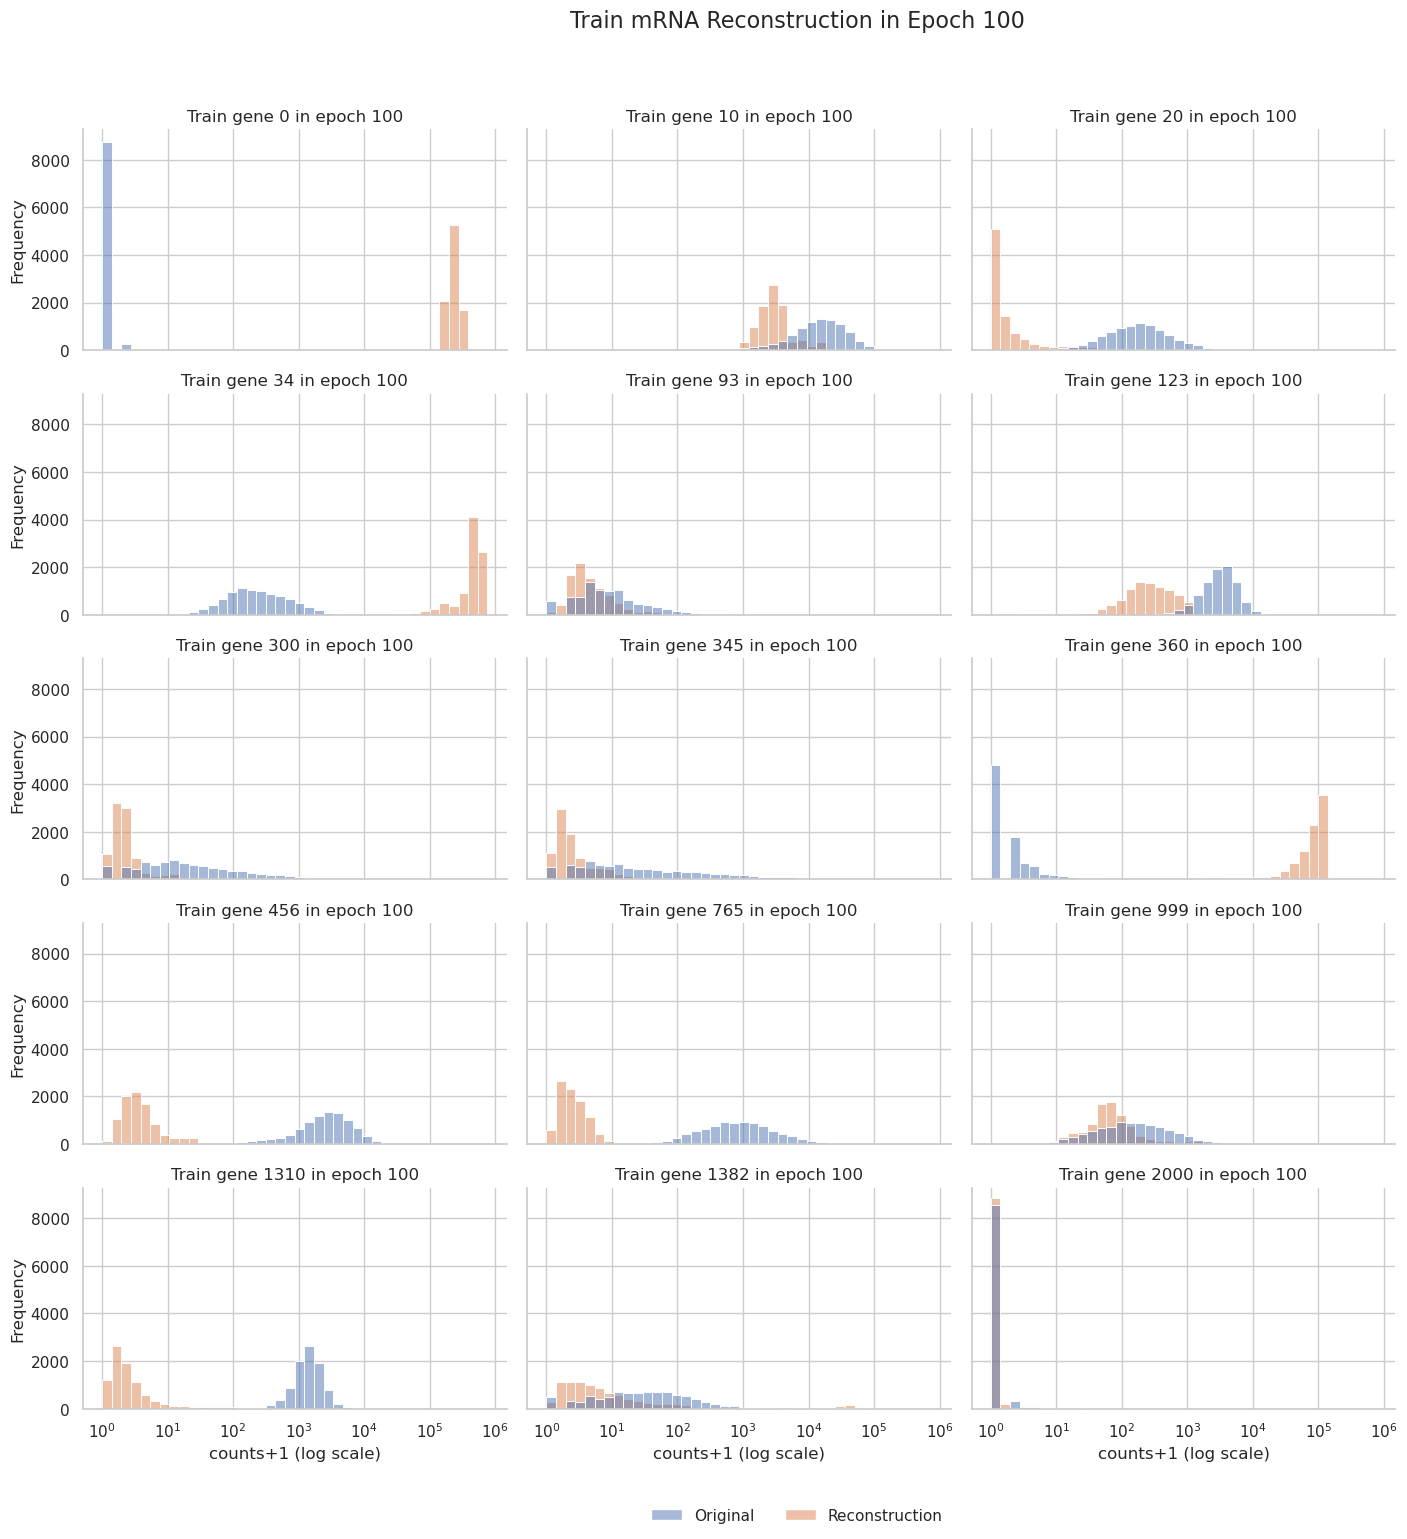

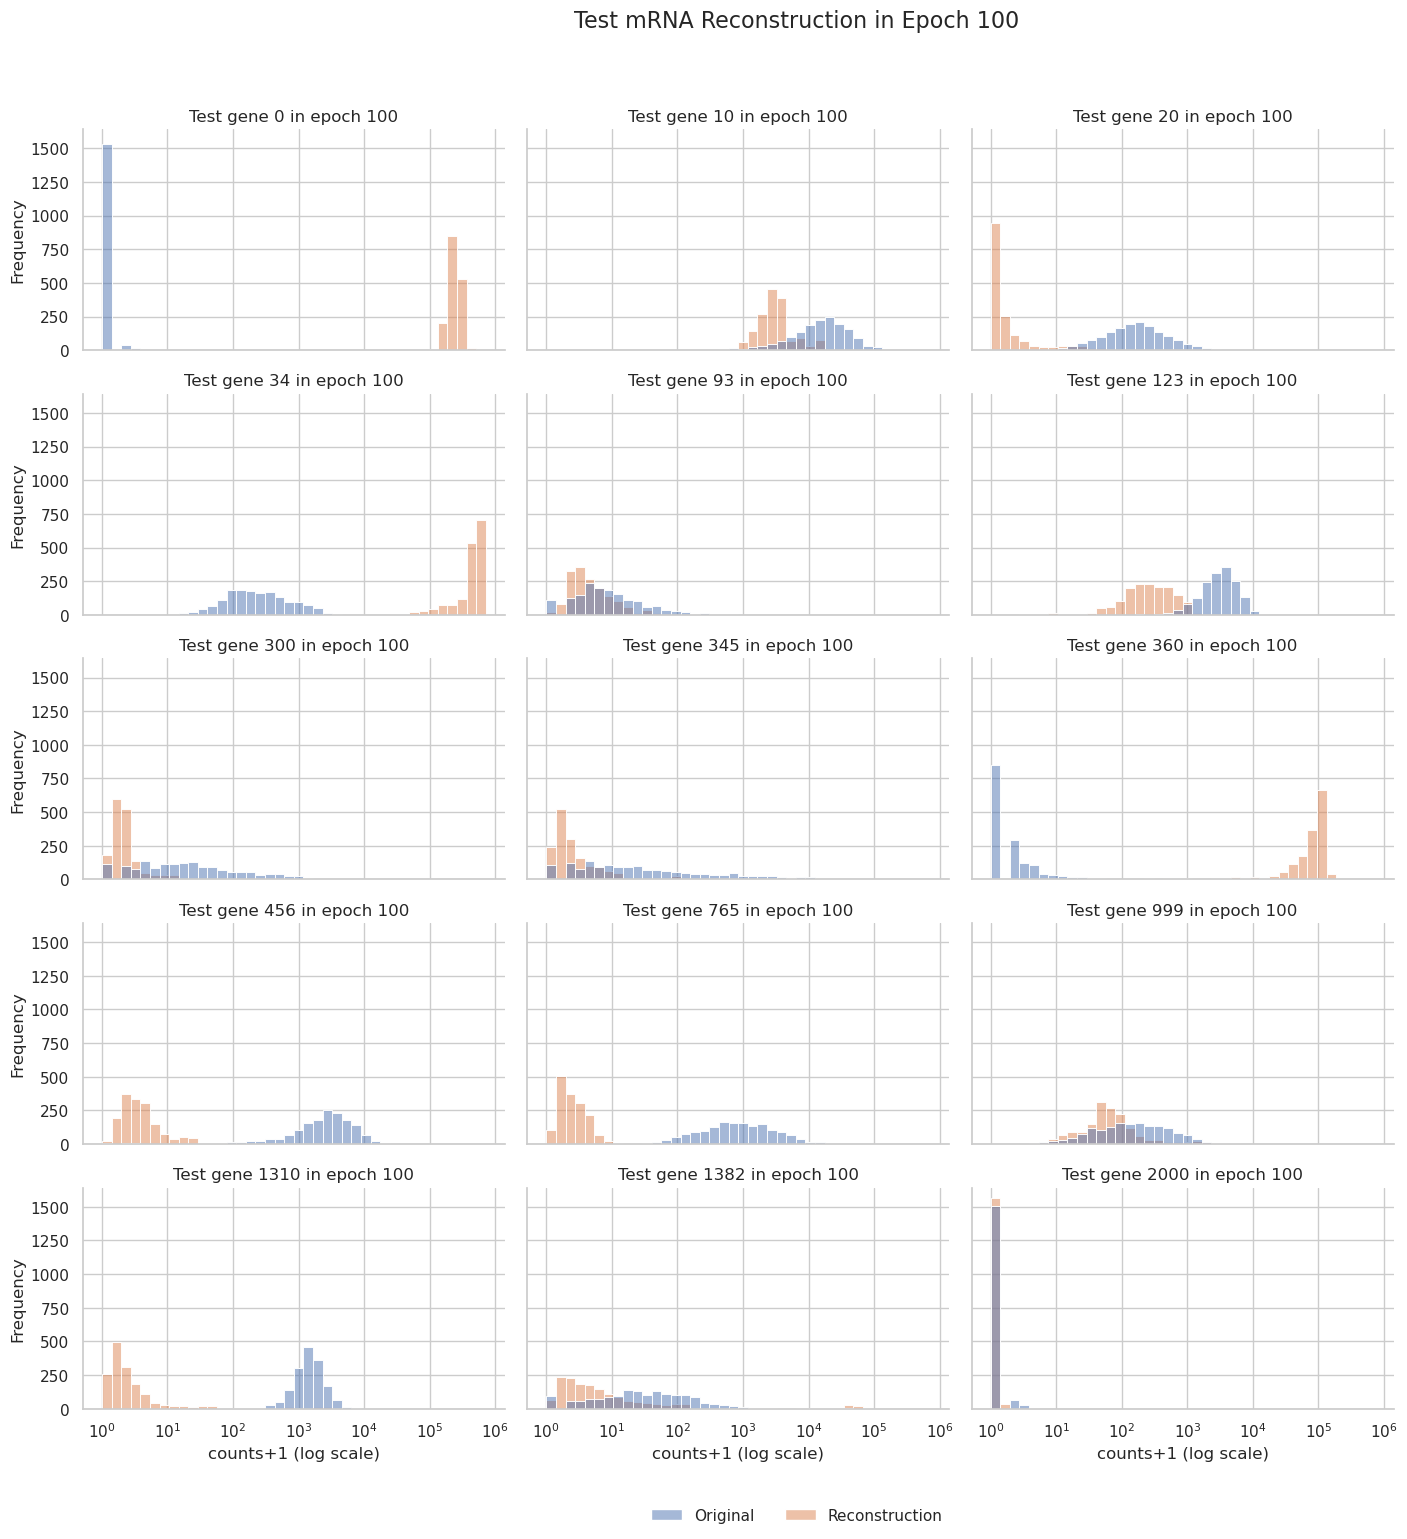

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [11:47<00:00,  7.01s/it]


In [109]:
loss_tab = train_midgd(
        dgd, train_loader, validation_loader, device, train_dataset, validation_dataset,
        learning_rates=learning_rates,
        weight_decay=weight_decay, betas=betas, nepochs=nepochs,
        pr=pr, plot=plot, reduction_type=reduction_type,
        sample_index=sample_index, wandb_log=False
    )

# Plotting Loss

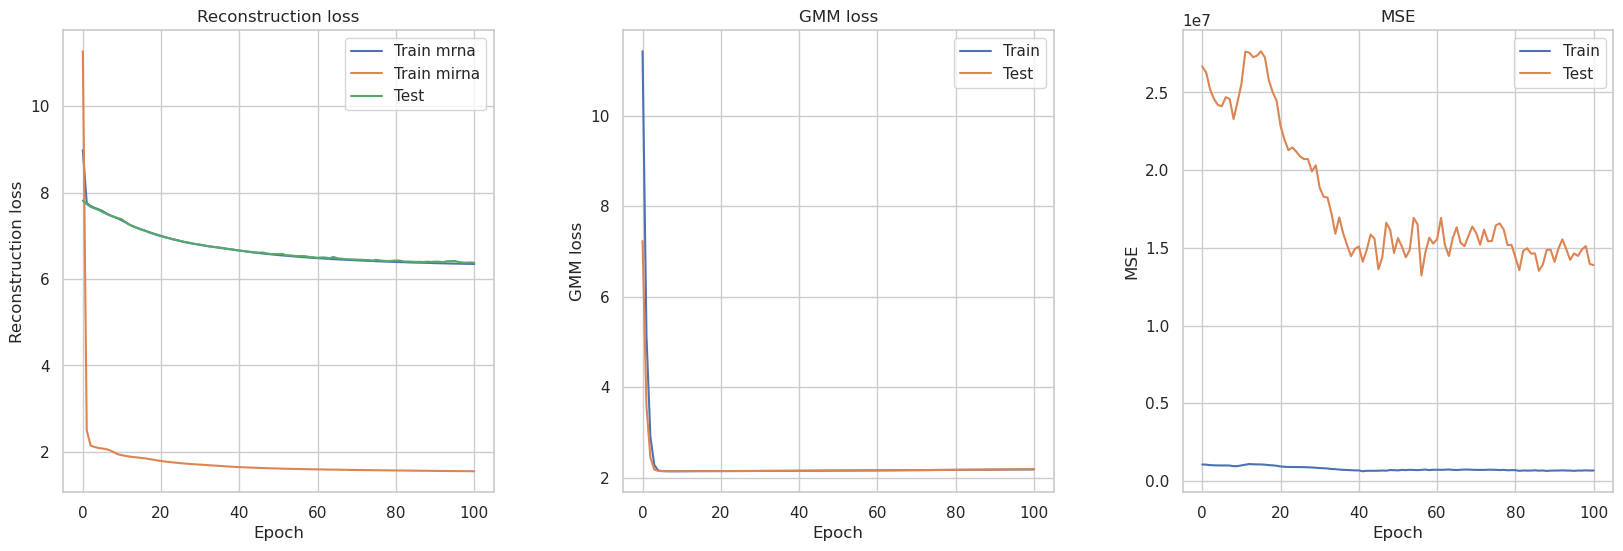

In [110]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_recon_mrna", data=loss_tab, label="Train mrna")
sns.lineplot(x="epoch", y="train_recon_mirna", data=loss_tab, label="Train mirna")
sns.lineplot(x="epoch", y="test_recon_mrna", data=loss_tab, label="Test")
plt.title("Reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

# Second subplot for GMM loss
plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_gmm", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_gmm", data=loss_tab, label="Test")
plt.title("GMM loss")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")

# Third subplot for RMSE
plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_mse", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mse", data=loss_tab, label="Test")
plt.title("MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Display the plots
plt.show()

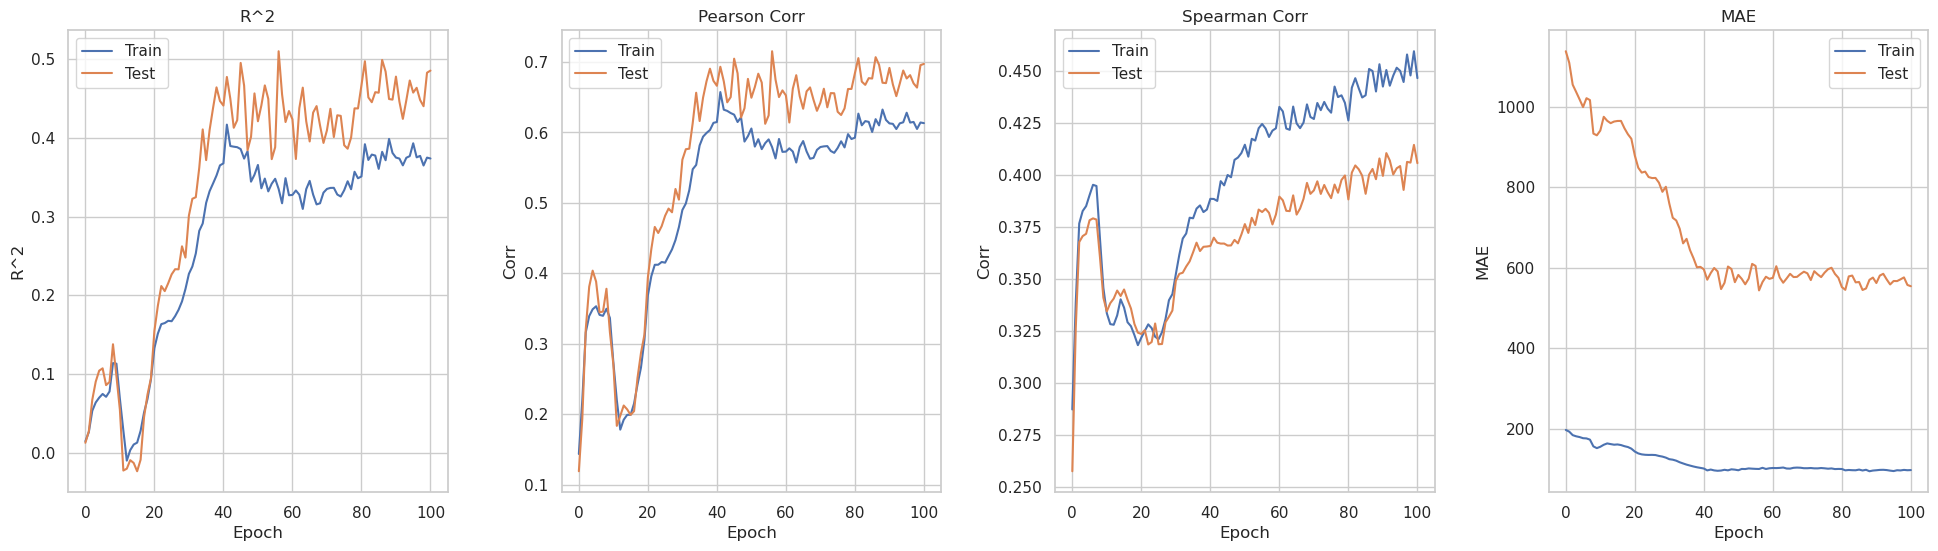

In [111]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for R-squared
plt.subplot(1, 4, 1)
sns.lineplot(x="epoch", y="train_r2", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_r2", data=loss_tab, label="Test")
plt.title("R^2")
plt.xlabel("Epoch")
plt.ylabel("R^2")

# Second subplot for Corr
plt.subplot(1, 4, 2)
sns.lineplot(x="epoch", y="train_pearson", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_pearson", data=loss_tab, label="Test")
plt.title("Pearson Corr")
plt.xlabel("Epoch")
plt.ylabel("Corr")

# Third subplot for MSE
plt.subplot(1, 4, 3)
sns.lineplot(x="epoch", y="train_spearman", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_spearman", data=loss_tab, label="Test")
plt.title("Spearman Corr")
plt.xlabel("Epoch")
plt.ylabel("Corr")

# Fourth subplot for MAE
plt.subplot(1, 4, 4)
sns.lineplot(x="epoch", y="train_mae", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mae", data=loss_tab, label="Test")
plt.title("MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")

# Display the plots
plt.show()

In [89]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (out_modules): ModuleList(
      (0): NB_Module(
        (fc): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(in_features=256, out_features=2450, bias=True)
        )
      )
      (1): NB_Module(
        (fc): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): LeakyReLU(negative_slope=0.01)
          (2): Linear(in_features=512, out_features=2500, bias=True)
        )
      )
    )
  )
  (gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (val_rep): RepresentationLayer()
)

In [95]:
dgd.decoder.main[2].state_dict()

OrderedDict([('weight',
              tensor([[ 0.0313, -0.0452,  0.0216,  ..., -0.0500,  0.0938, -0.2478],
                      [-0.1846, -0.0388, -0.2034,  ...,  0.0705,  0.1235,  0.1949],
                      [-0.0293,  0.0121,  0.0420,  ...,  0.1851, -0.1286,  0.0129],
                      ...,
                      [-0.0326,  0.0916,  0.1056,  ..., -0.0870,  0.1606,  0.0921],
                      [ 0.2640, -0.0806,  0.2726,  ...,  0.0502, -0.0967, -0.0417],
                      [ 0.0653,  0.0579, -0.1001,  ...,  0.1423, -0.0681,  0.0477]],
                     device='cuda:0')),
             ('bias',
              tensor([ 5.2492e-02, -8.3381e-02, -4.9043e-02, -1.3175e-01, -5.8876e-02,
                      -1.4262e-04,  6.8031e-02,  3.8040e-02,  4.5853e-02, -7.0847e-03,
                      -7.0271e-02, -1.4449e-01, -3.0226e-02, -4.0633e-02,  1.2368e-01,
                       1.0917e-02, -4.9740e-02,  6.7396e-02, -2.1181e-02,  1.7361e-01,
                      -1.5570e-01,

# Plotting